In [12]:
# -*- coding: utf-8 -*-
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from textblob import TextBlob, Word

import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag

from sklearn.pipeline import Pipeline, FeatureUnion
import scipy as sp



from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import TransformerMixin

from sklearn.cross_validation import cross_val_score

In [5]:
movie_ratings = pd.read_pickle('movie_ratings.pkl')

In [68]:

class SentimentMetrics(TransformerMixin):
    def changes (self, sentiments):
        N_changes = 0
        for i in range(len(sentiments)-1):
            if sentiments[i]*sentiments[i+1] < 0:
                N_changes+=1
        return N_changes     
    
    def sentiment(self, script, pages = 100, ma = 5):
        #Creates a moving average of the sentiment polarity of the script pages (or %)
        sentiment = []
        for i in range(pages+1-ma):
            sentiment.append(TextBlob(script[i*len(script)/pages:(i+ma)*len(script)/pages]).sentiment.polarity)
        return sentiment    
        
    def transform(self, X, **transform_params):  
        S = X.apply(lambda x: SentimentMetrics.sentiment(self, x))
        sentiment_dic = {
       'Range': S.apply(lambda x: max(x) - min(x)),
       #'Sentiment_avg': S.apply(lambda x: x.mean()),
       #'Sentiment_std': S.apply(lambda x: x.std()),
       'Max_sentiment': S.apply(lambda x: max(x)),
       'Max_sentiment_loc': S.apply(lambda x: x.index(max(x))),
       'Min_sentiment': S.apply(lambda x: min(x)),
       'Min_sentiment_loc': S.apply(lambda x: x.index(min(x))),
       'Max_pos_change': S.apply(lambda x: pd.Series(x).diff(1).max()),
       'Max_pos_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).max())),
       'Max_neg_change': S.apply(lambda x: pd.Series(x).diff(1).min()),
       'Max_neg_loc': S.apply(lambda x: list(pd.Series(x).diff(1)).index(pd.Series(x).diff(1).min())),
       'Begin_sentiment': S.apply(lambda x: x[0]),
       'End_sentiment': S.apply(lambda x: x[-1]),
       'Total_change': S.apply(lambda x: x[-1] - x[0]),
       'plot_twist_index': S.apply(lambda x: (max(x[-10:]) - min(x[-10:]))/(max(x[:-10]) - min(x[:-10]) + 0.01)),
       'pol_changes': S.apply(lambda x: SentimentMetrics.changes(self, x))
        }
            
        return sp.sparse.csr_matrix(pd.DataFrame(sentiment_dic).astype(float))
    
        
    
    def fit(self, X, y=None, **fit_params):
        return self      

class NamedEntities(TransformerMixin):        
    def number_entities(self, text):
        upper = [i for i in TextBlob(text).words if (i.isupper() and i.lower() not in stopwords.words('english'))]
        tagged = pos_tag(upper)
        return len(set([word for word,pos in tagged if pos == 'NNP']))
    
    def transform (self, X):
        return pd.DataFrame(X.apply(lambda x: NamedEntities.number_entities(self,x)))
    
    def fit(self, X, y=None, **fit_params):
        return self      
        
        

class SelectColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def transform(self, X, **transform_params):
        return X[self.column]
    
    def fit(self, X, y=None, **fit_params):
        return self      

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_tokenize(text, how='lemma'):
    words = TextBlob(text).words
    if how == 'lemma':
        return [word.lemmatize() for word in words]
    elif how == 'stem':
        return [stemmer.stem(word) for word in words]
    
def sentence_tokenize(text):
    words = TextBlob(text.replace(',', '.')).sentences
    return [word for word in words]
   
from sklearn import decomposition

from sklearn.base import BaseEstimator
class DenseTransformer(TransformerMixin, BaseEstimator):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
sent = SentimentMetrics()
X = sent.fit_transform(movie_ratings.script)
y = movie_ratings.imdbRating

In [8]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
import numpy as np
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1, verbose=3)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 30
building tree 2 of 30
building tree 3 of 30


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


building tree 39 of 40
building tree 40 of 40
building tree 1 of 40
building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40
building tree 9 of 40
building tree 10 of 40
building tree 11 of 40
building tree 12 of 40
building tree 13 of 40
building tree 14 of 40
building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40
building tree 20 of 40
building tree 21 of 40
building tree 22 of 40
building tree 23 of 40
building tree 24 of 40
building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40
building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60
building tree 1 of 60
building tree 2 of 60


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60
building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60
building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60
building tree 1 of 60
building tree 2 of 60
building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tree 60 of 60


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tr

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tr

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80
building tree 1 of 80
building tre

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80
building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80
building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 42 of 80
building tree 43 of 80
building tree 44 of 80
building tree 45 of 80
building tree 46 of 80
building tree 47 of 80
building tree 48 of 80
building tree 49 of 80
building tree 50 of 80
building tree 51 of 80
building tree 52 of 80
building tree 53 of 80
building tree 54 of 80
building tree 55 of 80
building tree 56 of 80
building tree 57 of 80
building tree 58 of 80
building tree 59 of 80
building tree 60 of 80
building tree 61 of 80
building tree 62 of 80
building tree 63 of 80
building tree 64 of 80
building tree 65 of 80
building tree 66 of 80
building tree 67 of 80
building tree 68 of 80
building tree 69 of 80
building tree 70 of 80
building tree 71 of 80
building tree 72 of 80
building tree 73 of 80
building tree 74 of 80
building tree 75 of 80
building tree 76 of 80
building tree 77 of 80
building tree 78 of 80
building tree 79 of 80
building tree 80 of 80


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.0s finished


building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tree 75 of 90
building tree 76 of 90
building tree 77 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished


building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tree 75 of 90
building tree 76 of 90
building tree 77 of 90
building tree 78 of 90
building tree 79 of 90
building tree 80 of 90
building tree 81 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished


building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tree 75 of 90
building tree 76 of 90
building tree 77 of 90
building tree 78 of 90
building tree 79 of 90
building tree 80 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished


building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tree 75 of 90
building tree 76 of 90
building tree 77 of 90
building tree 78 of 90
building tree 79 of 90
building tree 80 of 90
building tree 81 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished


building tree 1 of 90
building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90
building tree 8 of 90
building tree 9 of 90
building tree 10 of 90
building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90
building tree 19 of 90
building tree 20 of 90
building tree 21 of 90
building tree 22 of 90
building tree 23 of 90
building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 90
building tree 45 of 90
building tree 46 of 90
building tree 47 of 90
building tree 48 of 90
building tree 49 of 90
building tree 50 of 90
building tree 51 of 90
building tree 52 of 90
building tree 53 of 90
building tree 54 of 90
building tree 55 of 90
building tree 56 of 90
building tree 57 of 90
building tree 58 of 90
building tree 59 of 90
building tree 60 of 90
building tree 61 of 90
building tree 62 of 90
building tree 63 of 90
building tree 64 of 90
building tree 65 of 90
building tree 66 of 90
building tree 67 of 90
building tree 68 of 90
building tree 69 of 90
building tree 70 of 90
building tree 71 of 90
building tree 72 of 90
building tree 73 of 90
building tree 74 of 90
building tree 75 of 90
building tree 76 of 90
building tree 77 of 90
building tr

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.0s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


building tree 1 of 110
building tree 2 of 110
building tree 3 of 110
building tree 4 of 110
building tree 5 of 110
building tree 6 of 110
building tree 7 of 110
building tree 8 of 110
building tree 9 of 110
building tree 10 of 110
building tree 11 of 110
building tree 12 of 110
building tree 13 of 110
building tree 14 of 110
building tree 15 of 110
building tree 16 of 110
building tree 17 of 110
building tree 18 of 110
building tree 19 of 110
building tree 20 of 110
building tree 21 of 110
building tree 22 of 110
building tree 23 of 110
building tree 24 of 110
building tree 25 of 110
building tree 26 of 110
building tree 27 of 110
building tree 28 of 110
building tree 29 of 110
building tree 30 of 110
building tree 31 of 110
building tree 32 of 110
building tree 33 of 110
building tree 34 of 110


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 110
building tree 36 of 110
building tree 37 of 110
building tree 38 of 110
building tree 39 of 110
building tree 40 of 110
building tree 41 of 110
building tree 42 of 110
building tree 43 of 110
building tree 44 of 110
building tree 45 of 110
building tree 46 of 110
building tree 47 of 110
building tree 48 of 110
building tree 49 of 110
building tree 50 of 110
building tree 51 of 110
building tree 52 of 110
building tree 53 of 110
building tree 54 of 110
building tree 55 of 110
building tree 56 of 110
building tree 57 of 110
building tree 58 of 110
building tree 59 of 110
building tree 60 of 110
building tree 61 of 110
building tree 62 of 110
building tree 63 of 110
building tree 64 of 110
building tree 65 of 110
building tree 66 of 110
building tree 67 of 110
building tree 68 of 110
building tree 69 of 110
building tree 70 of 110
building tree 71 of 110
building tree 72 of 110
building tree 73 of 110
building tree 74 of 110
building tree 75 of 110
building tree 76

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


building tree 1 of 110
building tree 2 of 110
building tree 3 of 110
building tree 4 of 110
building tree 5 of 110
building tree 6 of 110
building tree 7 of 110
building tree 8 of 110
building tree 9 of 110
building tree 10 of 110
building tree 11 of 110
building tree 12 of 110
building tree 13 of 110
building tree 14 of 110
building tree 15 of 110
building tree 16 of 110
building tree 17 of 110
building tree 18 of 110
building tree 19 of 110
building tree 20 of 110
building tree 21 of 110
building tree 22 of 110
building tree 23 of 110
building tree 24 of 110
building tree 25 of 110
building tree 26 of 110
building tree 27 of 110
building tree 28 of 110
building tree 29 of 110
building tree 30 of 110
building tree 31 of 110
building tree 32 of 110
building tree 33 of 110
building tree 34 of 110
building tree 35 of 110


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 110
building tree 37 of 110
building tree 38 of 110
building tree 39 of 110
building tree 40 of 110
building tree 41 of 110
building tree 42 of 110
building tree 43 of 110
building tree 44 of 110
building tree 45 of 110
building tree 46 of 110
building tree 47 of 110
building tree 48 of 110
building tree 49 of 110
building tree 50 of 110
building tree 51 of 110
building tree 52 of 110
building tree 53 of 110
building tree 54 of 110
building tree 55 of 110
building tree 56 of 110
building tree 57 of 110
building tree 58 of 110
building tree 59 of 110
building tree 60 of 110
building tree 61 of 110
building tree 62 of 110
building tree 63 of 110
building tree 64 of 110
building tree 65 of 110
building tree 66 of 110
building tree 67 of 110
building tree 68 of 110
building tree 69 of 110
building tree 70 of 110
building tree 71 of 110
building tree 72 of 110
building tree 73 of 110
building tree 74 of 110
building tree 75 of 110
building tree 76 of 110
building tree 77

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


building tree 1 of 110
building tree 2 of 110
building tree 3 of 110
building tree 4 of 110
building tree 5 of 110
building tree 6 of 110
building tree 7 of 110
building tree 8 of 110
building tree 9 of 110
building tree 10 of 110
building tree 11 of 110
building tree 12 of 110
building tree 13 of 110
building tree 14 of 110
building tree 15 of 110
building tree 16 of 110
building tree 17 of 110
building tree 18 of 110
building tree 19 of 110
building tree 20 of 110
building tree 21 of 110
building tree 22 of 110
building tree 23 of 110
building tree 24 of 110
building tree 25 of 110
building tree 26 of 110
building tree 27 of 110
building tree 28 of 110
building tree 29 of 110
building tree 30 of 110
building tree 31 of 110
building tree 32 of 110
building tree 33 of 110
building tree 34 of 110
building tree 35 of 110
building tree 36 of 110
building tree 37 of 110
building tree 38 of 110
building tree 39 of 110


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 110
building tree 41 of 110
building tree 42 of 110
building tree 43 of 110
building tree 44 of 110
building tree 45 of 110
building tree 46 of 110
building tree 47 of 110
building tree 48 of 110
building tree 49 of 110
building tree 50 of 110
building tree 51 of 110
building tree 52 of 110
building tree 53 of 110
building tree 54 of 110
building tree 55 of 110
building tree 56 of 110
building tree 57 of 110
building tree 58 of 110
building tree 59 of 110
building tree 60 of 110
building tree 61 of 110
building tree 62 of 110
building tree 63 of 110
building tree 64 of 110
building tree 65 of 110
building tree 66 of 110
building tree 67 of 110
building tree 68 of 110
building tree 69 of 110
building tree 70 of 110
building tree 71 of 110
building tree 72 of 110
building tree 73 of 110
building tree 74 of 110
building tree 75 of 110
building tree 76 of 110
building tree 77 of 110
building tree 78 of 110
building tree 79 of 110
building tree 80 of 110
building tree 81

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


building tree 1 of 110
building tree 2 of 110
building tree 3 of 110
building tree 4 of 110
building tree 5 of 110
building tree 6 of 110
building tree 7 of 110
building tree 8 of 110
building tree 9 of 110
building tree 10 of 110
building tree 11 of 110
building tree 12 of 110
building tree 13 of 110
building tree 14 of 110
building tree 15 of 110
building tree 16 of 110
building tree 17 of 110
building tree 18 of 110
building tree 19 of 110
building tree 20 of 110
building tree 21 of 110
building tree 22 of 110
building tree 23 of 110
building tree 24 of 110
building tree 25 of 110
building tree 26 of 110
building tree 27 of 110
building tree 28 of 110
building tree 29 of 110
building tree 30 of 110
building tree 31 of 110
building tree 32 of 110
building tree 33 of 110
building tree 34 of 110
building tree 35 of 110
building tree 36 of 110
building tree 37 of 110
building tree 38 of 110


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 110
building tree 40 of 110
building tree 41 of 110
building tree 42 of 110
building tree 43 of 110
building tree 44 of 110
building tree 45 of 110
building tree 46 of 110
building tree 47 of 110
building tree 48 of 110
building tree 49 of 110
building tree 50 of 110
building tree 51 of 110
building tree 52 of 110
building tree 53 of 110
building tree 54 of 110
building tree 55 of 110
building tree 56 of 110
building tree 57 of 110
building tree 58 of 110
building tree 59 of 110
building tree 60 of 110
building tree 61 of 110
building tree 62 of 110
building tree 63 of 110
building tree 64 of 110
building tree 65 of 110
building tree 66 of 110
building tree 67 of 110
building tree 68 of 110
building tree 69 of 110
building tree 70 of 110
building tree 71 of 110
building tree 72 of 110
building tree 73 of 110
building tree 74 of 110
building tree 75 of 110
building tree 76 of 110
building tree 77 of 110
building tree 78 of 110
building tree 79 of 110
building tree 80

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


building tree 1 of 110
building tree 2 of 110
building tree 3 of 110
building tree 4 of 110
building tree 5 of 110
building tree 6 of 110
building tree 7 of 110
building tree 8 of 110
building tree 9 of 110
building tree 10 of 110
building tree 11 of 110
building tree 12 of 110
building tree 13 of 110
building tree 14 of 110
building tree 15 of 110
building tree 16 of 110
building tree 17 of 110
building tree 18 of 110
building tree 19 of 110
building tree 20 of 110
building tree 21 of 110
building tree 22 of 110
building tree 23 of 110
building tree 24 of 110
building tree 25 of 110
building tree 26 of 110
building tree 27 of 110
building tree 28 of 110
building tree 29 of 110
building tree 30 of 110
building tree 31 of 110
building tree 32 of 110
building tree 33 of 110
building tree 34 of 110
building tree 35 of 110
building tree 36 of 110
building tree 37 of 110
building tree 38 of 110
building tree 39 of 110
building tree 40 of 110


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 110
building tree 42 of 110
building tree 43 of 110
building tree 44 of 110
building tree 45 of 110
building tree 46 of 110
building tree 47 of 110
building tree 48 of 110
building tree 49 of 110
building tree 50 of 110
building tree 51 of 110
building tree 52 of 110
building tree 53 of 110
building tree 54 of 110
building tree 55 of 110
building tree 56 of 110
building tree 57 of 110
building tree 58 of 110
building tree 59 of 110
building tree 60 of 110
building tree 61 of 110
building tree 62 of 110
building tree 63 of 110
building tree 64 of 110
building tree 65 of 110
building tree 66 of 110
building tree 67 of 110
building tree 68 of 110
building tree 69 of 110
building tree 70 of 110
building tree 71 of 110
building tree 72 of 110
building tree 73 of 110
building tree 74 of 110
building tree 75 of 110
building tree 76 of 110
building tree 77 of 110
building tree 78 of 110
building tree 79 of 110
building tree 80 of 110
building tree 81 of 110
building tree 82

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.0s finished


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 120
building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


building tree 1 of 120
building tree 2 of 120
building tree 3 of 120
building tree 4 of 120
building tree 5 of 120
building tree 6 of 120
building tree 7 of 120
building tree 8 of 120
building tree 9 of 120
building tree 10 of 120
building tree 11 of 120
building tree 12 of 120
building tree 13 of 120
building tree 14 of 120
building tree 15 of 120
building tree 16 of 120
building tree 17 of 120
building tree 18 of 120
building tree 19 of 120
building tree 20 of 120
building tree 21 of 120
building tree 22 of 120
building tree 23 of 120
building tree 24 of 120
building tree 25 of 120
building tree 26 of 120
building tree 27 of 120
building tree 28 of 120
building tree 29 of 120
building tree 30 of 120
building tree 31 of 120
building tree 32 of 120
building tree 33 of 120
building tree 34 of 120
building tree 35 of 120
building tree 36 of 120
building tree 37 of 120
building tree 38 of 120


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 120
building tree 40 of 120
building tree 41 of 120
building tree 42 of 120
building tree 43 of 120
building tree 44 of 120
building tree 45 of 120
building tree 46 of 120
building tree 47 of 120
building tree 48 of 120
building tree 49 of 120
building tree 50 of 120
building tree 51 of 120
building tree 52 of 120
building tree 53 of 120
building tree 54 of 120
building tree 55 of 120
building tree 56 of 120
building tree 57 of 120
building tree 58 of 120
building tree 59 of 120
building tree 60 of 120
building tree 61 of 120
building tree 62 of 120
building tree 63 of 120
building tree 64 of 120
building tree 65 of 120
building tree 66 of 120
building tree 67 of 120
building tree 68 of 120
building tree 69 of 120
building tree 70 of 120
building tree 71 of 120
building tree 72 of 120
building tree 73 of 120
building tree 74 of 120
building tree 75 of 120
building tree 76 of 120
building tree 77 of 120
building tree 78 of 120
building tree 79 of 120
building tree 80

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130
building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


building tree 1 of 130
building tree 2 of 130
building tree 3 of 130
building tree 4 of 130
building tree 5 of 130
building tree 6 of 130
building tree 7 of 130
building tree 8 of 130
building tree 9 of 130
building tree 10 of 130
building tree 11 of 130
building tree 12 of 130
building tree 13 of 130
building tree 14 of 130
building tree 15 of 130
building tree 16 of 130
building tree 17 of 130
building tree 18 of 130
building tree 19 of 130
building tree 20 of 130
building tree 21 of 130
building tree 22 of 130
building tree 23 of 130
building tree 24 of 130
building tree 25 of 130
building tree 26 of 130
building tree 27 of 130
building tree 28 of 130
building tree 29 of 130
building tree 30 of 130
building tree 31 of 130
building tree 32 of 130
building tree 33 of 130
building tree 34 of 130
building tree 35 of 130
building tree 36 of 130
building tree 37 of 130
building tree 38 of 130
building tree 39 of 130
building tree 40 of 130


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 130
building tree 42 of 130
building tree 43 of 130
building tree 44 of 130
building tree 45 of 130
building tree 46 of 130
building tree 47 of 130
building tree 48 of 130
building tree 49 of 130
building tree 50 of 130
building tree 51 of 130
building tree 52 of 130
building tree 53 of 130
building tree 54 of 130
building tree 55 of 130
building tree 56 of 130
building tree 57 of 130
building tree 58 of 130
building tree 59 of 130
building tree 60 of 130
building tree 61 of 130
building tree 62 of 130
building tree 63 of 130
building tree 64 of 130
building tree 65 of 130
building tree 66 of 130
building tree 67 of 130
building tree 68 of 130
building tree 69 of 130
building tree 70 of 130
building tree 71 of 130
building tree 72 of 130
building tree 73 of 130
building tree 74 of 130
building tree 75 of 130
building tree 76 of 130
building tree 77 of 130
building tree 78 of 130
building tree 79 of 130
building tree 80 of 130
building tree 81 of 130
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.0s finished


building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 of 140
building tree 35 of 140
building tree 36 of 140
building tree 37 of 140


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 140
building tree 39 of 140
building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


building tree 133 of 140
building tree 134 of 140
building tree 135 of 140
building tree 136 of 140
building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140
building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 140
building tree 39 of 140
building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


building tree 128 of 140
building tree 129 of 140
building tree 130 of 140
building tree 131 of 140
building tree 132 of 140
building tree 133 of 140
building tree 134 of 140
building tree 135 of 140
building tree 136 of 140
building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140
building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tre

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


building tree 133 of 140
building tree 134 of 140
building tree 135 of 140
building tree 136 of 140
building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140
building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tree 29 of 140
building tree 30 of 140
building tree 31 of 140
building tree 32 of 140
building tree 33 of 140
building tree 34 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80 of 140
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


building tree 128 of 140
building tree 129 of 140
building tree 130 of 140
building tree 131 of 140
building tree 132 of 140
building tree 133 of 140
building tree 134 of 140
building tree 135 of 140
building tree 136 of 140
building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140
building tree 1 of 140
building tree 2 of 140
building tree 3 of 140
building tree 4 of 140
building tree 5 of 140
building tree 6 of 140
building tree 7 of 140
building tree 8 of 140
building tree 9 of 140
building tree 10 of 140
building tree 11 of 140
building tree 12 of 140
building tree 13 of 140
building tree 14 of 140
building tree 15 of 140
building tree 16 of 140
building tree 17 of 140
building tree 18 of 140
building tree 19 of 140
building tree 20 of 140
building tree 21 of 140
building tree 22 of 140
building tree 23 of 140
building tree 24 of 140
building tree 25 of 140
building tree 26 of 140
building tree 27 of 140
building tree 28 of 140
building tre

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 140
building tree 40 of 140
building tree 41 of 140
building tree 42 of 140
building tree 43 of 140
building tree 44 of 140
building tree 45 of 140
building tree 46 of 140
building tree 47 of 140
building tree 48 of 140
building tree 49 of 140
building tree 50 of 140
building tree 51 of 140
building tree 52 of 140
building tree 53 of 140
building tree 54 of 140
building tree 55 of 140
building tree 56 of 140
building tree 57 of 140
building tree 58 of 140
building tree 59 of 140
building tree 60 of 140
building tree 61 of 140
building tree 62 of 140
building tree 63 of 140
building tree 64 of 140
building tree 65 of 140
building tree 66 of 140
building tree 67 of 140
building tree 68 of 140
building tree 69 of 140
building tree 70 of 140
building tree 71 of 140
building tree 72 of 140
building tree 73 of 140
building tree 74 of 140
building tree 75 of 140
building tree 76 of 140
building tree 77 of 140
building tree 78 of 140
building tree 79 of 140
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.0s finished


building tree 134 of 140
building tree 135 of 140
building tree 136 of 140
building tree 137 of 140
building tree 138 of 140
building tree 139 of 140
building tree 140 of 140
building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 o

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150
building tree 142 of 150
building tree 143 of 150
building tree 144 of 150
building tree 145 of 150
building tree 146 of 150
building tree 147 of 150
building tree 148 of 150
building tree 149 of 150
building tree 150 of 150


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160
building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s



building tree 129 of 160
building tree 130 of 160
building tree 131 of 160
building tree 132 of 160
building tree 133 of 160
building tree 134 of 160
building tree 135 of 160
building tree 136 of 160
building tree 137 of 160
building tree 138 of 160
building tree 139 of 160
building tree 140 of 160
building tree 141 of 160
building tree 142 of 160
building tree 143 of 160
building tree 144 of 160
building tree 145 of 160
building tree 146 of 160
building tree 147 of 160
building tree 148 of 160
building tree 149 of 160
building tree 150 of 160
building tree 151 of 160
building tree 152 of 160
building tree 153 of 160
building tree 154 of 160
building tree 155 of 160
building tree 156 of 160
building tree 157 of 160
building tree 158 of 160
building tree 159 of 160
building tree 160 of 160


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 160
building tree 40 of 160
building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 160
building tree 135 of 160
building tree 136 of 160
building tree 137 of 160
building tree 138 of 160
building tree 139 of 160
building tree 140 of 160
building tree 141 of 160
building tree 142 of 160
building tree 143 of 160
building tree 144 of 160
building tree 145 of 160
building tree 146 of 160
building tree 147 of 160
building tree 148 of 160
building tree 149 of 160
building tree 150 of 160
building tree 151 of 160
building tree 152 of 160
building tree 153 of 160
building tree 154 of 160
building tree 155 of 160
building tree 156 of 160
building tree 157 of 160
building tree 158 of 160
building tree 159 of 160
building tree 160 of 160


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 160
building tree 40 of 160
building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 160
building tree 135 of 160
building tree 136 of 160
building tree 137 of 160
building tree 138 of 160
building tree 139 of 160
building tree 140 of 160
building tree 141 of 160
building tree 142 of 160
building tree 143 of 160
building tree 144 of 160
building tree 145 of 160
building tree 146 of 160
building tree 147 of 160
building tree 148 of 160
building tree 149 of 160
building tree 150 of 160
building tree 151 of 160
building tree 152 of 160
building tree 153 of 160
building tree 154 of 160
building tree 155 of 160
building tree 156 of 160
building tree 157 of 160
building tree 158 of 160
building tree 159 of 160
building tree 160 of 160


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 160
building tree 40 of 160
building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 160
building tree 136 of 160
building tree 137 of 160
building tree 138 of 160
building tree 139 of 160
building tree 140 of 160
building tree 141 of 160
building tree 142 of 160
building tree 143 of 160
building tree 144 of 160
building tree 145 of 160
building tree 146 of 160
building tree 147 of 160
building tree 148 of 160
building tree 149 of 160
building tree 150 of 160
building tree 151 of 160
building tree 152 of 160
building tree 153 of 160
building tree 154 of 160
building tree 155 of 160
building tree 156 of 160
building tree 157 of 160
building tree 158 of 160
building tree 159 of 160
building tree 160 of 160


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished


building tree 1 of 160
building tree 2 of 160
building tree 3 of 160
building tree 4 of 160
building tree 5 of 160
building tree 6 of 160
building tree 7 of 160
building tree 8 of 160
building tree 9 of 160
building tree 10 of 160
building tree 11 of 160
building tree 12 of 160
building tree 13 of 160
building tree 14 of 160
building tree 15 of 160
building tree 16 of 160
building tree 17 of 160
building tree 18 of 160
building tree 19 of 160
building tree 20 of 160
building tree 21 of 160
building tree 22 of 160
building tree 23 of 160
building tree 24 of 160
building tree 25 of 160
building tree 26 of 160
building tree 27 of 160
building tree 28 of 160
building tree 29 of 160
building tree 30 of 160
building tree 31 of 160
building tree 32 of 160
building tree 33 of 160
building tree 34 of 160
building tree 35 of 160
building tree 36 of 160
building tree 37 of 160
building tree 38 of 160
building tree 39 of 160
building tree 40 of 160


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 160
building tree 42 of 160
building tree 43 of 160
building tree 44 of 160
building tree 45 of 160
building tree 46 of 160
building tree 47 of 160
building tree 48 of 160
building tree 49 of 160
building tree 50 of 160
building tree 51 of 160
building tree 52 of 160
building tree 53 of 160
building tree 54 of 160
building tree 55 of 160
building tree 56 of 160
building tree 57 of 160
building tree 58 of 160
building tree 59 of 160
building tree 60 of 160
building tree 61 of 160
building tree 62 of 160
building tree 63 of 160
building tree 64 of 160
building tree 65 of 160
building tree 66 of 160
building tree 67 of 160
building tree 68 of 160
building tree 69 of 160
building tree 70 of 160
building tree 71 of 160
building tree 72 of 160
building tree 73 of 160
building tree 74 of 160
building tree 75 of 160
building tree 76 of 160
building tree 77 of 160
building tree 78 of 160
building tree 79 of 160
building tree 80 of 160
building tree 81 of 160
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 140 of 160
building tree 141 of 160
building tree 142 of 160
building tree 143 of 160
building tree 144 of 160
building tree 145 of 160
building tree 146 of 160
building tree 147 of 160
building tree 148 of 160
building tree 149 of 160
building tree 150 of 160
building tree 151 of 160
building tree 152 of 160
building tree 153 of 160
building tree 154 of 160
building tree 155 of 160
building tree 156 of 160
building tree 157 of 160
building tree 158 of 160
building tree 159 of 160
building tree 160 of 160


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:    0.0s finished


building tree 1 of 170
building tree 2 of 170
building tree 3 of 170
building tree 4 of 170
building tree 5 of 170
building tree 6 of 170
building tree 7 of 170
building tree 8 of 170
building tree 9 of 170
building tree 10 of 170
building tree 11 of 170
building tree 12 of 170
building tree 13 of 170
building tree 14 of 170
building tree 15 of 170
building tree 16 of 170
building tree 17 of 170
building tree 18 of 170
building tree 19 of 170
building tree 20 of 170
building tree 21 of 170
building tree 22 of 170
building tree 23 of 170
building tree 24 of 170
building tree 25 of 170
building tree 26 of 170
building tree 27 of 170
building tree 28 of 170
building tree 29 of 170
building tree 30 of 170
building tree 31 of 170
building tree 32 of 170
building tree 33 of 170
building tree 34 of 170
building tree 35 of 170
building tree 36 of 170
building tree 37 of 170
building tree 38 of 170


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 170
building tree 40 of 170
building tree 41 of 170
building tree 42 of 170
building tree 43 of 170
building tree 44 of 170
building tree 45 of 170
building tree 46 of 170
building tree 47 of 170
building tree 48 of 170
building tree 49 of 170
building tree 50 of 170
building tree 51 of 170
building tree 52 of 170
building tree 53 of 170
building tree 54 of 170
building tree 55 of 170
building tree 56 of 170
building tree 57 of 170
building tree 58 of 170
building tree 59 of 170
building tree 60 of 170
building tree 61 of 170
building tree 62 of 170
building tree 63 of 170
building tree 64 of 170
building tree 65 of 170
building tree 66 of 170
building tree 67 of 170
building tree 68 of 170
building tree 69 of 170
building tree 70 of 170
building tree 71 of 170
building tree 72 of 170
building tree 73 of 170
building tree 74 of 170
building tree 75 of 170
building tree 76 of 170
building tree 77 of 170
building tree 78 of 170
building tree 79 of 170
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 170
building tree 135 of 170
building tree 136 of 170
building tree 137 of 170
building tree 138 of 170
building tree 139 of 170
building tree 140 of 170
building tree 141 of 170
building tree 142 of 170
building tree 143 of 170
building tree 144 of 170
building tree 145 of 170
building tree 146 of 170
building tree 147 of 170
building tree 148 of 170
building tree 149 of 170
building tree 150 of 170
building tree 151 of 170
building tree 152 of 170
building tree 153 of 170
building tree 154 of 170
building tree 155 of 170
building tree 156 of 170
building tree 157 of 170
building tree 158 of 170
building tree 159 of 170
building tree 160 of 170
building tree 161 of 170
building tree 162 of 170
building tree 163 of 170
building tree 164 of 170
building tree 165 of 170
building tree 166 of 170
building tree 167 of 170
building tree 168 of 170
building tree 169 of 170
building tree 170 of 170


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.0s finished


building tree 1 of 170
building tree 2 of 170
building tree 3 of 170
building tree 4 of 170
building tree 5 of 170
building tree 6 of 170
building tree 7 of 170
building tree 8 of 170
building tree 9 of 170
building tree 10 of 170
building tree 11 of 170
building tree 12 of 170
building tree 13 of 170
building tree 14 of 170
building tree 15 of 170
building tree 16 of 170
building tree 17 of 170
building tree 18 of 170
building tree 19 of 170
building tree 20 of 170
building tree 21 of 170
building tree 22 of 170
building tree 23 of 170
building tree 24 of 170
building tree 25 of 170
building tree 26 of 170
building tree 27 of 170
building tree 28 of 170
building tree 29 of 170
building tree 30 of 170
building tree 31 of 170
building tree 32 of 170
building tree 33 of 170
building tree 34 of 170
building tree 35 of 170
building tree 36 of 170
building tree 37 of 170
building tree 38 of 170


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 170
building tree 40 of 170
building tree 41 of 170
building tree 42 of 170
building tree 43 of 170
building tree 44 of 170
building tree 45 of 170
building tree 46 of 170
building tree 47 of 170
building tree 48 of 170
building tree 49 of 170
building tree 50 of 170
building tree 51 of 170
building tree 52 of 170
building tree 53 of 170
building tree 54 of 170
building tree 55 of 170
building tree 56 of 170
building tree 57 of 170
building tree 58 of 170
building tree 59 of 170
building tree 60 of 170
building tree 61 of 170
building tree 62 of 170
building tree 63 of 170
building tree 64 of 170
building tree 65 of 170
building tree 66 of 170
building tree 67 of 170
building tree 68 of 170
building tree 69 of 170
building tree 70 of 170
building tree 71 of 170
building tree 72 of 170
building tree 73 of 170
building tree 74 of 170
building tree 75 of 170
building tree 76 of 170
building tree 77 of 170
building tree 78 of 170
building tree 79 of 170
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 170
building tree 137 of 170
building tree 138 of 170
building tree 139 of 170
building tree 140 of 170
building tree 141 of 170
building tree 142 of 170
building tree 143 of 170
building tree 144 of 170
building tree 145 of 170
building tree 146 of 170
building tree 147 of 170
building tree 148 of 170
building tree 149 of 170
building tree 150 of 170
building tree 151 of 170
building tree 152 of 170
building tree 153 of 170
building tree 154 of 170
building tree 155 of 170
building tree 156 of 170
building tree 157 of 170
building tree 158 of 170
building tree 159 of 170
building tree 160 of 170
building tree 161 of 170
building tree 162 of 170
building tree 163 of 170
building tree 164 of 170
building tree 165 of 170
building tree 166 of 170
building tree 167 of 170
building tree 168 of 170
building tree 169 of 170
building tree 170 of 170


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.0s finished


building tree 1 of 170
building tree 2 of 170
building tree 3 of 170
building tree 4 of 170
building tree 5 of 170
building tree 6 of 170
building tree 7 of 170
building tree 8 of 170
building tree 9 of 170
building tree 10 of 170
building tree 11 of 170
building tree 12 of 170
building tree 13 of 170
building tree 14 of 170
building tree 15 of 170
building tree 16 of 170
building tree 17 of 170
building tree 18 of 170
building tree 19 of 170
building tree 20 of 170
building tree 21 of 170
building tree 22 of 170
building tree 23 of 170
building tree 24 of 170
building tree 25 of 170
building tree 26 of 170
building tree 27 of 170
building tree 28 of 170
building tree 29 of 170
building tree 30 of 170
building tree 31 of 170
building tree 32 of 170
building tree 33 of 170
building tree 34 of 170
building tree 35 of 170
building tree 36 of 170
building tree 37 of 170
building tree 38 of 170


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 170
building tree 40 of 170
building tree 41 of 170
building tree 42 of 170
building tree 43 of 170
building tree 44 of 170
building tree 45 of 170
building tree 46 of 170
building tree 47 of 170
building tree 48 of 170
building tree 49 of 170
building tree 50 of 170
building tree 51 of 170
building tree 52 of 170
building tree 53 of 170
building tree 54 of 170
building tree 55 of 170
building tree 56 of 170
building tree 57 of 170
building tree 58 of 170
building tree 59 of 170
building tree 60 of 170
building tree 61 of 170
building tree 62 of 170
building tree 63 of 170
building tree 64 of 170
building tree 65 of 170
building tree 66 of 170
building tree 67 of 170
building tree 68 of 170
building tree 69 of 170
building tree 70 of 170
building tree 71 of 170
building tree 72 of 170
building tree 73 of 170
building tree 74 of 170
building tree 75 of 170
building tree 76 of 170
building tree 77 of 170
building tree 78 of 170
building tree 79 of 170
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 170
building tree 135 of 170
building tree 136 of 170
building tree 137 of 170
building tree 138 of 170
building tree 139 of 170
building tree 140 of 170
building tree 141 of 170
building tree 142 of 170
building tree 143 of 170
building tree 144 of 170
building tree 145 of 170
building tree 146 of 170
building tree 147 of 170
building tree 148 of 170
building tree 149 of 170
building tree 150 of 170
building tree 151 of 170
building tree 152 of 170
building tree 153 of 170
building tree 154 of 170
building tree 155 of 170
building tree 156 of 170
building tree 157 of 170
building tree 158 of 170
building tree 159 of 170
building tree 160 of 170
building tree 161 of 170
building tree 162 of 170
building tree 163 of 170
building tree 164 of 170
building tree 165 of 170
building tree 166 of 170
building tree 167 of 170
building tree 168 of 170
building tree 169 of 170
building tree 170 of 170


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.0s finished


building tree 1 of 170
building tree 2 of 170
building tree 3 of 170
building tree 4 of 170
building tree 5 of 170
building tree 6 of 170
building tree 7 of 170
building tree 8 of 170
building tree 9 of 170
building tree 10 of 170
building tree 11 of 170
building tree 12 of 170
building tree 13 of 170
building tree 14 of 170
building tree 15 of 170
building tree 16 of 170
building tree 17 of 170
building tree 18 of 170
building tree 19 of 170
building tree 20 of 170
building tree 21 of 170
building tree 22 of 170
building tree 23 of 170
building tree 24 of 170
building tree 25 of 170
building tree 26 of 170
building tree 27 of 170
building tree 28 of 170
building tree 29 of 170
building tree 30 of 170
building tree 31 of 170
building tree 32 of 170
building tree 33 of 170
building tree 34 of 170
building tree 35 of 170
building tree 36 of 170
building tree 37 of 170
building tree 38 of 170
building tree 39 of 170


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 170
building tree 41 of 170
building tree 42 of 170
building tree 43 of 170
building tree 44 of 170
building tree 45 of 170
building tree 46 of 170
building tree 47 of 170
building tree 48 of 170
building tree 49 of 170
building tree 50 of 170
building tree 51 of 170
building tree 52 of 170
building tree 53 of 170
building tree 54 of 170
building tree 55 of 170
building tree 56 of 170
building tree 57 of 170
building tree 58 of 170
building tree 59 of 170
building tree 60 of 170
building tree 61 of 170
building tree 62 of 170
building tree 63 of 170
building tree 64 of 170
building tree 65 of 170
building tree 66 of 170
building tree 67 of 170
building tree 68 of 170
building tree 69 of 170
building tree 70 of 170
building tree 71 of 170
building tree 72 of 170
building tree 73 of 170
building tree 74 of 170
building tree 75 of 170
building tree 76 of 170
building tree 77 of 170
building tree 78 of 170
building tree 79 of 170
building tree 80 of 170
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 170
building tree 137 of 170
building tree 138 of 170
building tree 139 of 170
building tree 140 of 170
building tree 141 of 170
building tree 142 of 170
building tree 143 of 170
building tree 144 of 170
building tree 145 of 170
building tree 146 of 170
building tree 147 of 170
building tree 148 of 170
building tree 149 of 170
building tree 150 of 170
building tree 151 of 170
building tree 152 of 170
building tree 153 of 170
building tree 154 of 170
building tree 155 of 170
building tree 156 of 170
building tree 157 of 170
building tree 158 of 170
building tree 159 of 170
building tree 160 of 170
building tree 161 of 170
building tree 162 of 170
building tree 163 of 170
building tree 164 of 170
building tree 165 of 170
building tree 166 of 170
building tree 167 of 170
building tree 168 of 170
building tree 169 of 170
building tree 170 of 170


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.0s finished


building tree 1 of 170
building tree 2 of 170
building tree 3 of 170
building tree 4 of 170
building tree 5 of 170
building tree 6 of 170
building tree 7 of 170
building tree 8 of 170
building tree 9 of 170
building tree 10 of 170
building tree 11 of 170
building tree 12 of 170
building tree 13 of 170
building tree 14 of 170
building tree 15 of 170
building tree 16 of 170
building tree 17 of 170
building tree 18 of 170
building tree 19 of 170
building tree 20 of 170
building tree 21 of 170
building tree 22 of 170
building tree 23 of 170
building tree 24 of 170
building tree 25 of 170
building tree 26 of 170
building tree 27 of 170
building tree 28 of 170
building tree 29 of 170
building tree 30 of 170
building tree 31 of 170
building tree 32 of 170
building tree 33 of 170
building tree 34 of 170
building tree 35 of 170
building tree 36 of 170
building tree 37 of 170
building tree 38 of 170


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 170
building tree 40 of 170
building tree 41 of 170
building tree 42 of 170
building tree 43 of 170
building tree 44 of 170
building tree 45 of 170
building tree 46 of 170
building tree 47 of 170
building tree 48 of 170
building tree 49 of 170
building tree 50 of 170
building tree 51 of 170
building tree 52 of 170
building tree 53 of 170
building tree 54 of 170
building tree 55 of 170
building tree 56 of 170
building tree 57 of 170
building tree 58 of 170
building tree 59 of 170
building tree 60 of 170
building tree 61 of 170
building tree 62 of 170
building tree 63 of 170
building tree 64 of 170
building tree 65 of 170
building tree 66 of 170
building tree 67 of 170
building tree 68 of 170
building tree 69 of 170
building tree 70 of 170
building tree 71 of 170
building tree 72 of 170
building tree 73 of 170
building tree 74 of 170
building tree 75 of 170
building tree 76 of 170
building tree 77 of 170
building tree 78 of 170
building tree 79 of 170
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 170
building tree 137 of 170
building tree 138 of 170
building tree 139 of 170
building tree 140 of 170
building tree 141 of 170
building tree 142 of 170
building tree 143 of 170
building tree 144 of 170
building tree 145 of 170
building tree 146 of 170
building tree 147 of 170
building tree 148 of 170
building tree 149 of 170
building tree 150 of 170
building tree 151 of 170
building tree 152 of 170
building tree 153 of 170
building tree 154 of 170
building tree 155 of 170
building tree 156 of 170
building tree 157 of 170
building tree 158 of 170
building tree 159 of 170
building tree 160 of 170
building tree 161 of 170
building tree 162 of 170
building tree 163 of 170
building tree 164 of 170
building tree 165 of 170
building tree 166 of 170
building tree 167 of 170
building tree 168 of 170
building tree 169 of 170
building tree 170 of 170


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.0s finished


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 180
building tree 137 of 180
building tree 138 of 180
building tree 139 of 180
building tree 140 of 180
building tree 141 of 180
building tree 142 of 180
building tree 143 of 180
building tree 144 of 180
building tree 145 of 180
building tree 146 of 180
building tree 147 of 180
building tree 148 of 180
building tree 149 of 180
building tree 150 of 180
building tree 151 of 180
building tree 152 of 180
building tree 153 of 180
building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 138 of 180
building tree 139 of 180
building tree 140 of 180
building tree 141 of 180
building tree 142 of 180
building tree 143 of 180
building tree 144 of 180
building tree 145 of 180
building tree 146 of 180
building tree 147 of 180
building tree 148 of 180
building tree 149 of 180
building tree 150 of 180
building tree 151 of 180
building tree 152 of 180
building tree 153 of 180
building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180
building tree 174 of 180
building tree 175 of 180
building tree 176 of 180
building tree 177 of 180


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180
building tree 39 of 180


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80 of 180
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 180
building tree 135 of 180
building tree 136 of 180
building tree 137 of 180
building tree 138 of 180
building tree 139 of 180
building tree 140 of 180
building tree 141 of 180
building tree 142 of 180
building tree 143 of 180
building tree 144 of 180
building tree 145 of 180
building tree 146 of 180
building tree 147 of 180
building tree 148 of 180
building tree 149 of 180
building tree 150 of 180
building tree 151 of 180
building tree 152 of 180
building tree 153 of 180
building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 133 of 180
building tree 134 of 180
building tree 135 of 180
building tree 136 of 180
building tree 137 of 180
building tree 138 of 180
building tree 139 of 180
building tree 140 of 180
building tree 141 of 180
building tree 142 of 180
building tree 143 of 180
building tree 144 of 180
building tree 145 of 180
building tree 146 of 180
building tree 147 of 180
building tree 148 of 180
building tree 149 of 180
building tree 150 of 180
building tree 151 of 180
building tree 152 of 180
building tree 153 of 180
building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


building tree 1 of 180
building tree 2 of 180
building tree 3 of 180
building tree 4 of 180
building tree 5 of 180
building tree 6 of 180
building tree 7 of 180
building tree 8 of 180
building tree 9 of 180
building tree 10 of 180
building tree 11 of 180
building tree 12 of 180
building tree 13 of 180
building tree 14 of 180
building tree 15 of 180
building tree 16 of 180
building tree 17 of 180
building tree 18 of 180
building tree 19 of 180
building tree 20 of 180
building tree 21 of 180
building tree 22 of 180
building tree 23 of 180
building tree 24 of 180
building tree 25 of 180
building tree 26 of 180
building tree 27 of 180
building tree 28 of 180
building tree 29 of 180
building tree 30 of 180
building tree 31 of 180
building tree 32 of 180
building tree 33 of 180
building tree 34 of 180
building tree 35 of 180
building tree 36 of 180
building tree 37 of 180
building tree 38 of 180


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 180
building tree 40 of 180
building tree 41 of 180
building tree 42 of 180
building tree 43 of 180
building tree 44 of 180
building tree 45 of 180
building tree 46 of 180
building tree 47 of 180
building tree 48 of 180
building tree 49 of 180
building tree 50 of 180
building tree 51 of 180
building tree 52 of 180
building tree 53 of 180
building tree 54 of 180
building tree 55 of 180
building tree 56 of 180
building tree 57 of 180
building tree 58 of 180
building tree 59 of 180
building tree 60 of 180
building tree 61 of 180
building tree 62 of 180
building tree 63 of 180
building tree 64 of 180
building tree 65 of 180
building tree 66 of 180
building tree 67 of 180
building tree 68 of 180
building tree 69 of 180
building tree 70 of 180
building tree 71 of 180
building tree 72 of 180
building tree 73 of 180
building tree 74 of 180
building tree 75 of 180
building tree 76 of 180
building tree 77 of 180
building tree 78 of 180
building tree 79 of 180
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 180
building tree 135 of 180
building tree 136 of 180
building tree 137 of 180
building tree 138 of 180
building tree 139 of 180
building tree 140 of 180
building tree 141 of 180
building tree 142 of 180
building tree 143 of 180
building tree 144 of 180
building tree 145 of 180
building tree 146 of 180
building tree 147 of 180
building tree 148 of 180
building tree 149 of 180
building tree 150 of 180
building tree 151 of 180
building tree 152 of 180
building tree 153 of 180
building tree 154 of 180
building tree 155 of 180
building tree 156 of 180
building tree 157 of 180
building tree 158 of 180
building tree 159 of 180
building tree 160 of 180
building tree 161 of 180
building tree 162 of 180
building tree 163 of 180
building tree 164 of 180
building tree 165 of 180
building tree 166 of 180
building tree 167 of 180
building tree 168 of 180
building tree 169 of 180
building tree 170 of 180
building tree 171 of 180
building tree 172 of 180
building tree 173 of 180


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.0s finished


building tree 1 of 190
building tree 2 of 190
building tree 3 of 190
building tree 4 of 190
building tree 5 of 190
building tree 6 of 190
building tree 7 of 190
building tree 8 of 190
building tree 9 of 190
building tree 10 of 190
building tree 11 of 190
building tree 12 of 190
building tree 13 of 190
building tree 14 of 190
building tree 15 of 190
building tree 16 of 190
building tree 17 of 190
building tree 18 of 190
building tree 19 of 190
building tree 20 of 190
building tree 21 of 190
building tree 22 of 190
building tree 23 of 190
building tree 24 of 190
building tree 25 of 190
building tree 26 of 190
building tree 27 of 190
building tree 28 of 190
building tree 29 of 190
building tree 30 of 190
building tree 31 of 190
building tree 32 of 190
building tree 33 of 190
building tree 34 of 190
building tree 35 of 190
building tree 36 of 190
building tree 37 of 190
building tree 38 of 190


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 190
building tree 40 of 190
building tree 41 of 190
building tree 42 of 190
building tree 43 of 190
building tree 44 of 190
building tree 45 of 190
building tree 46 of 190
building tree 47 of 190
building tree 48 of 190
building tree 49 of 190
building tree 50 of 190
building tree 51 of 190
building tree 52 of 190
building tree 53 of 190
building tree 54 of 190
building tree 55 of 190
building tree 56 of 190
building tree 57 of 190
building tree 58 of 190
building tree 59 of 190
building tree 60 of 190
building tree 61 of 190
building tree 62 of 190
building tree 63 of 190
building tree 64 of 190
building tree 65 of 190
building tree 66 of 190
building tree 67 of 190
building tree 68 of 190
building tree 69 of 190
building tree 70 of 190
building tree 71 of 190
building tree 72 of 190
building tree 73 of 190
building tree 74 of 190
building tree 75 of 190
building tree 76 of 190
building tree 77 of 190
building tree 78 of 190
building tree 79 of 190
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 190
building tree 135 of 190
building tree 136 of 190
building tree 137 of 190
building tree 138 of 190
building tree 139 of 190
building tree 140 of 190
building tree 141 of 190
building tree 142 of 190
building tree 143 of 190
building tree 144 of 190
building tree 145 of 190
building tree 146 of 190
building tree 147 of 190
building tree 148 of 190
building tree 149 of 190
building tree 150 of 190
building tree 151 of 190
building tree 152 of 190
building tree 153 of 190
building tree 154 of 190
building tree 155 of 190
building tree 156 of 190
building tree 157 of 190
building tree 158 of 190
building tree 159 of 190
building tree 160 of 190
building tree 161 of 190
building tree 162 of 190
building tree 163 of 190
building tree 164 of 190
building tree 165 of 190
building tree 166 of 190
building tree 167 of 190
building tree 168 of 190
building tree 169 of 190
building tree 170 of 190
building tree 171 of 190
building tree 172 of 190
building tree 173 of 190


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.0s finished


building tree 1 of 190
building tree 2 of 190
building tree 3 of 190
building tree 4 of 190
building tree 5 of 190
building tree 6 of 190
building tree 7 of 190
building tree 8 of 190
building tree 9 of 190
building tree 10 of 190
building tree 11 of 190
building tree 12 of 190
building tree 13 of 190
building tree 14 of 190
building tree 15 of 190
building tree 16 of 190
building tree 17 of 190
building tree 18 of 190
building tree 19 of 190
building tree 20 of 190
building tree 21 of 190
building tree 22 of 190
building tree 23 of 190
building tree 24 of 190
building tree 25 of 190
building tree 26 of 190
building tree 27 of 190
building tree 28 of 190
building tree 29 of 190
building tree 30 of 190
building tree 31 of 190
building tree 32 of 190
building tree 33 of 190
building tree 34 of 190
building tree 35 of 190


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 190
building tree 37 of 190
building tree 38 of 190
building tree 39 of 190
building tree 40 of 190
building tree 41 of 190
building tree 42 of 190
building tree 43 of 190
building tree 44 of 190
building tree 45 of 190
building tree 46 of 190
building tree 47 of 190
building tree 48 of 190
building tree 49 of 190
building tree 50 of 190
building tree 51 of 190
building tree 52 of 190
building tree 53 of 190
building tree 54 of 190
building tree 55 of 190
building tree 56 of 190
building tree 57 of 190
building tree 58 of 190
building tree 59 of 190
building tree 60 of 190
building tree 61 of 190
building tree 62 of 190
building tree 63 of 190
building tree 64 of 190
building tree 65 of 190
building tree 66 of 190
building tree 67 of 190
building tree 68 of 190
building tree 69 of 190
building tree 70 of 190
building tree 71 of 190
building tree 72 of 190
building tree 73 of 190
building tree 74 of 190
building tree 75 of 190
building tree 76 of 190
building tree 77

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 131 of 190
building tree 132 of 190
building tree 133 of 190
building tree 134 of 190
building tree 135 of 190
building tree 136 of 190
building tree 137 of 190
building tree 138 of 190
building tree 139 of 190
building tree 140 of 190
building tree 141 of 190
building tree 142 of 190
building tree 143 of 190
building tree 144 of 190
building tree 145 of 190
building tree 146 of 190
building tree 147 of 190
building tree 148 of 190
building tree 149 of 190
building tree 150 of 190
building tree 151 of 190
building tree 152 of 190
building tree 153 of 190
building tree 154 of 190
building tree 155 of 190
building tree 156 of 190
building tree 157 of 190
building tree 158 of 190
building tree 159 of 190
building tree 160 of 190
building tree 161 of 190
building tree 162 of 190
building tree 163 of 190
building tree 164 of 190
building tree 165 of 190
building tree 166 of 190
building tree 167 of 190
building tree 168 of 190
building tree 169 of 190
building tree 170 of 190


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.0s finished


building tree 1 of 190
building tree 2 of 190
building tree 3 of 190
building tree 4 of 190
building tree 5 of 190
building tree 6 of 190
building tree 7 of 190
building tree 8 of 190
building tree 9 of 190
building tree 10 of 190
building tree 11 of 190
building tree 12 of 190
building tree 13 of 190
building tree 14 of 190
building tree 15 of 190
building tree 16 of 190
building tree 17 of 190
building tree 18 of 190
building tree 19 of 190
building tree 20 of 190
building tree 21 of 190
building tree 22 of 190
building tree 23 of 190
building tree 24 of 190
building tree 25 of 190
building tree 26 of 190
building tree 27 of 190
building tree 28 of 190
building tree 29 of 190
building tree 30 of 190
building tree 31 of 190
building tree 32 of 190
building tree 33 of 190
building tree 34 of 190
building tree 35 of 190
building tree 36 of 190
building tree 37 of 190
building tree 38 of 190
building tree 39 of 190


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 190
building tree 41 of 190
building tree 42 of 190
building tree 43 of 190
building tree 44 of 190
building tree 45 of 190
building tree 46 of 190
building tree 47 of 190
building tree 48 of 190
building tree 49 of 190
building tree 50 of 190
building tree 51 of 190
building tree 52 of 190
building tree 53 of 190
building tree 54 of 190
building tree 55 of 190
building tree 56 of 190
building tree 57 of 190
building tree 58 of 190
building tree 59 of 190
building tree 60 of 190
building tree 61 of 190
building tree 62 of 190
building tree 63 of 190
building tree 64 of 190
building tree 65 of 190
building tree 66 of 190
building tree 67 of 190
building tree 68 of 190
building tree 69 of 190
building tree 70 of 190
building tree 71 of 190
building tree 72 of 190
building tree 73 of 190
building tree 74 of 190
building tree 75 of 190
building tree 76 of 190
building tree 77 of 190
building tree 78 of 190
building tree 79 of 190
building tree 80 of 190
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 143 of 190
building tree 144 of 190
building tree 145 of 190
building tree 146 of 190
building tree 147 of 190
building tree 148 of 190
building tree 149 of 190
building tree 150 of 190
building tree 151 of 190
building tree 152 of 190
building tree 153 of 190
building tree 154 of 190
building tree 155 of 190
building tree 156 of 190
building tree 157 of 190
building tree 158 of 190
building tree 159 of 190
building tree 160 of 190
building tree 161 of 190
building tree 162 of 190
building tree 163 of 190
building tree 164 of 190
building tree 165 of 190
building tree 166 of 190
building tree 167 of 190
building tree 168 of 190
building tree 169 of 190
building tree 170 of 190
building tree 171 of 190
building tree 172 of 190
building tree 173 of 190
building tree 174 of 190
building tree 175 of 190
building tree 176 of 190
building tree 177 of 190
building tree 178 of 190
building tree 179 of 190
building tree 180 of 190
building tree 181 of 190
building tree 182 of 190


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.0s finished


building tree 1 of 190
building tree 2 of 190
building tree 3 of 190
building tree 4 of 190
building tree 5 of 190
building tree 6 of 190
building tree 7 of 190
building tree 8 of 190
building tree 9 of 190
building tree 10 of 190
building tree 11 of 190
building tree 12 of 190
building tree 13 of 190
building tree 14 of 190
building tree 15 of 190
building tree 16 of 190
building tree 17 of 190
building tree 18 of 190
building tree 19 of 190
building tree 20 of 190
building tree 21 of 190
building tree 22 of 190
building tree 23 of 190
building tree 24 of 190
building tree 25 of 190
building tree 26 of 190
building tree 27 of 190
building tree 28 of 190
building tree 29 of 190
building tree 30 of 190
building tree 31 of 190
building tree 32 of 190
building tree 33 of 190
building tree 34 of 190
building tree 35 of 190
building tree 36 of 190
building tree 37 of 190
building tree 38 of 190


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 190
building tree 40 of 190
building tree 41 of 190
building tree 42 of 190
building tree 43 of 190
building tree 44 of 190
building tree 45 of 190
building tree 46 of 190
building tree 47 of 190
building tree 48 of 190
building tree 49 of 190
building tree 50 of 190
building tree 51 of 190
building tree 52 of 190
building tree 53 of 190
building tree 54 of 190
building tree 55 of 190
building tree 56 of 190
building tree 57 of 190
building tree 58 of 190
building tree 59 of 190
building tree 60 of 190
building tree 61 of 190
building tree 62 of 190
building tree 63 of 190
building tree 64 of 190
building tree 65 of 190
building tree 66 of 190
building tree 67 of 190
building tree 68 of 190
building tree 69 of 190
building tree 70 of 190
building tree 71 of 190
building tree 72 of 190
building tree 73 of 190
building tree 74 of 190
building tree 75 of 190
building tree 76 of 190
building tree 77 of 190
building tree 78 of 190
building tree 79 of 190
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.5s


building tree 141 of 190
building tree 142 of 190
building tree 143 of 190
building tree 144 of 190
building tree 145 of 190
building tree 146 of 190
building tree 147 of 190
building tree 148 of 190
building tree 149 of 190
building tree 150 of 190
building tree 151 of 190
building tree 152 of 190
building tree 153 of 190
building tree 154 of 190
building tree 155 of 190
building tree 156 of 190
building tree 157 of 190
building tree 158 of 190
building tree 159 of 190
building tree 160 of 190
building tree 161 of 190
building tree 162 of 190
building tree 163 of 190
building tree 164 of 190
building tree 165 of 190
building tree 166 of 190
building tree 167 of 190
building tree 168 of 190
building tree 169 of 190
building tree 170 of 190
building tree 171 of 190
building tree 172 of 190
building tree 173 of 190
building tree 174 of 190
building tree 175 of 190
building tree 176 of 190
building tree 177 of 190
building tree 178 of 190
building tree 179 of 190
building tree 180 of 190


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.0s finished


building tree 1 of 190
building tree 2 of 190
building tree 3 of 190
building tree 4 of 190
building tree 5 of 190
building tree 6 of 190
building tree 7 of 190
building tree 8 of 190
building tree 9 of 190
building tree 10 of 190
building tree 11 of 190
building tree 12 of 190
building tree 13 of 190
building tree 14 of 190
building tree 15 of 190
building tree 16 of 190
building tree 17 of 190
building tree 18 of 190
building tree 19 of 190
building tree 20 of 190
building tree 21 of 190
building tree 22 of 190
building tree 23 of 190
building tree 24 of 190
building tree 25 of 190
building tree 26 of 190
building tree 27 of 190
building tree 28 of 190
building tree 29 of 190
building tree 30 of 190
building tree 31 of 190
building tree 32 of 190
building tree 33 of 190
building tree 34 of 190
building tree 35 of 190
building tree 36 of 190
building tree 37 of 190
building tree 38 of 190


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 190
building tree 40 of 190
building tree 41 of 190
building tree 42 of 190
building tree 43 of 190
building tree 44 of 190
building tree 45 of 190
building tree 46 of 190
building tree 47 of 190
building tree 48 of 190
building tree 49 of 190
building tree 50 of 190
building tree 51 of 190
building tree 52 of 190
building tree 53 of 190
building tree 54 of 190
building tree 55 of 190
building tree 56 of 190
building tree 57 of 190
building tree 58 of 190
building tree 59 of 190
building tree 60 of 190
building tree 61 of 190
building tree 62 of 190
building tree 63 of 190
building tree 64 of 190
building tree 65 of 190
building tree 66 of 190
building tree 67 of 190
building tree 68 of 190
building tree 69 of 190
building tree 70 of 190
building tree 71 of 190
building tree 72 of 190
building tree 73 of 190
building tree 74 of 190
building tree 75 of 190
building tree 76 of 190
building tree 77 of 190
building tree 78 of 190
building tree 79 of 190
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 128 of 190
building tree 129 of 190
building tree 130 of 190
building tree 131 of 190
building tree 132 of 190
building tree 133 of 190
building tree 134 of 190
building tree 135 of 190
building tree 136 of 190
building tree 137 of 190
building tree 138 of 190
building tree 139 of 190
building tree 140 of 190
building tree 141 of 190
building tree 142 of 190
building tree 143 of 190
building tree 144 of 190
building tree 145 of 190
building tree 146 of 190
building tree 147 of 190
building tree 148 of 190
building tree 149 of 190
building tree 150 of 190
building tree 151 of 190
building tree 152 of 190
building tree 153 of 190
building tree 154 of 190
building tree 155 of 190
building tree 156 of 190
building tree 157 of 190
building tree 158 of 190
building tree 159 of 190
building tree 160 of 190
building tree 161 of 190
building tree 162 of 190
building tree 163 of 190
building tree 164 of 190
building tree 165 of 190
building tree 166 of 190
building tree 167 of 190


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


building tree 1 of 210
building tree 2 of 210
building tree 3 of 210
building tree 4 of 210
building tree 5 of 210
building tree 6 of 210
building tree 7 of 210
building tree 8 of 210
building tree 9 of 210
building tree 10 of 210
building tree 11 of 210
building tree 12 of 210
building tree 13 of 210
building tree 14 of 210
building tree 15 of 210
building tree 16 of 210
building tree 17 of 210
building tree 18 of 210
building tree 19 of 210
building tree 20 of 210
building tree 21 of 210
building tree 22 of 210
building tree 23 of 210
building tree 24 of 210
building tree 25 of 210
building tree 26 of 210
building tree 27 of 210
building tree 28 of 210
building tree 29 of 210
building tree 30 of 210
building tree 31 of 210
building tree 32 of 210
building tree 33 of 210
building tree 34 of 210
building tree 35 of 210
building tree 36 of 210
building tree 37 of 210
building tree 38 of 210
building tree 39 of 210
building tree 40 of 210


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 210
building tree 42 of 210
building tree 43 of 210
building tree 44 of 210
building tree 45 of 210
building tree 46 of 210
building tree 47 of 210
building tree 48 of 210
building tree 49 of 210
building tree 50 of 210
building tree 51 of 210
building tree 52 of 210
building tree 53 of 210
building tree 54 of 210
building tree 55 of 210
building tree 56 of 210
building tree 57 of 210
building tree 58 of 210
building tree 59 of 210
building tree 60 of 210
building tree 61 of 210
building tree 62 of 210
building tree 63 of 210
building tree 64 of 210
building tree 65 of 210
building tree 66 of 210
building tree 67 of 210
building tree 68 of 210
building tree 69 of 210
building tree 70 of 210
building tree 71 of 210
building tree 72 of 210
building tree 73 of 210
building tree 74 of 210
building tree 75 of 210
building tree 76 of 210
building tree 77 of 210
building tree 78 of 210
building tree 79 of 210
building tree 80 of 210
building tree 81 of 210
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 138 of 210
building tree 139 of 210
building tree 140 of 210
building tree 141 of 210
building tree 142 of 210
building tree 143 of 210
building tree 144 of 210
building tree 145 of 210
building tree 146 of 210
building tree 147 of 210
building tree 148 of 210
building tree 149 of 210
building tree 150 of 210
building tree 151 of 210
building tree 152 of 210
building tree 153 of 210
building tree 154 of 210
building tree 155 of 210
building tree 156 of 210
building tree 157 of 210
building tree 158 of 210
building tree 159 of 210
building tree 160 of 210
building tree 161 of 210
building tree 162 of 210
building tree 163 of 210
building tree 164 of 210
building tree 165 of 210
building tree 166 of 210
building tree 167 of 210
building tree 168 of 210
building tree 169 of 210
building tree 170 of 210
building tree 171 of 210
building tree 172 of 210
building tree 173 of 210
building tree 174 of 210
building tree 175 of 210
building tree 176 of 210
building tree 177 of 210


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.0s finished


building tree 1 of 210
building tree 2 of 210
building tree 3 of 210
building tree 4 of 210
building tree 5 of 210
building tree 6 of 210
building tree 7 of 210
building tree 8 of 210
building tree 9 of 210
building tree 10 of 210
building tree 11 of 210
building tree 12 of 210
building tree 13 of 210
building tree 14 of 210
building tree 15 of 210
building tree 16 of 210
building tree 17 of 210
building tree 18 of 210
building tree 19 of 210
building tree 20 of 210
building tree 21 of 210
building tree 22 of 210
building tree 23 of 210
building tree 24 of 210
building tree 25 of 210
building tree 26 of 210
building tree 27 of 210
building tree 28 of 210
building tree 29 of 210
building tree 30 of 210
building tree 31 of 210
building tree 32 of 210
building tree 33 of 210
building tree 34 of 210
building tree 35 of 210
building tree 36 of 210
building tree 37 of 210
building tree 38 of 210


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 210
building tree 40 of 210
building tree 41 of 210
building tree 42 of 210
building tree 43 of 210
building tree 44 of 210
building tree 45 of 210
building tree 46 of 210
building tree 47 of 210
building tree 48 of 210
building tree 49 of 210
building tree 50 of 210
building tree 51 of 210
building tree 52 of 210
building tree 53 of 210
building tree 54 of 210
building tree 55 of 210
building tree 56 of 210
building tree 57 of 210
building tree 58 of 210
building tree 59 of 210
building tree 60 of 210
building tree 61 of 210
building tree 62 of 210
building tree 63 of 210
building tree 64 of 210
building tree 65 of 210
building tree 66 of 210
building tree 67 of 210
building tree 68 of 210
building tree 69 of 210
building tree 70 of 210
building tree 71 of 210
building tree 72 of 210
building tree 73 of 210
building tree 74 of 210
building tree 75 of 210
building tree 76 of 210
building tree 77 of 210
building tree 78 of 210
building tree 79 of 210
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 131 of 210
building tree 132 of 210
building tree 133 of 210
building tree 134 of 210
building tree 135 of 210
building tree 136 of 210
building tree 137 of 210
building tree 138 of 210
building tree 139 of 210
building tree 140 of 210
building tree 141 of 210
building tree 142 of 210
building tree 143 of 210
building tree 144 of 210
building tree 145 of 210
building tree 146 of 210
building tree 147 of 210
building tree 148 of 210
building tree 149 of 210
building tree 150 of 210
building tree 151 of 210
building tree 152 of 210
building tree 153 of 210
building tree 154 of 210
building tree 155 of 210
building tree 156 of 210
building tree 157 of 210
building tree 158 of 210
building tree 159 of 210
building tree 160 of 210
building tree 161 of 210
building tree 162 of 210
building tree 163 of 210
building tree 164 of 210
building tree 165 of 210
building tree 166 of 210
building tree 167 of 210
building tree 168 of 210
building tree 169 of 210
building tree 170 of 210


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.0s finished


building tree 1 of 210
building tree 2 of 210
building tree 3 of 210
building tree 4 of 210
building tree 5 of 210
building tree 6 of 210
building tree 7 of 210
building tree 8 of 210
building tree 9 of 210
building tree 10 of 210
building tree 11 of 210
building tree 12 of 210
building tree 13 of 210
building tree 14 of 210
building tree 15 of 210
building tree 16 of 210
building tree 17 of 210
building tree 18 of 210
building tree 19 of 210
building tree 20 of 210
building tree 21 of 210
building tree 22 of 210
building tree 23 of 210
building tree 24 of 210
building tree 25 of 210
building tree 26 of 210
building tree 27 of 210
building tree 28 of 210
building tree 29 of 210
building tree 30 of 210
building tree 31 of 210
building tree 32 of 210


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 210
building tree 34 of 210
building tree 35 of 210
building tree 36 of 210
building tree 37 of 210
building tree 38 of 210
building tree 39 of 210
building tree 40 of 210
building tree 41 of 210
building tree 42 of 210
building tree 43 of 210
building tree 44 of 210
building tree 45 of 210
building tree 46 of 210
building tree 47 of 210
building tree 48 of 210
building tree 49 of 210
building tree 50 of 210
building tree 51 of 210
building tree 52 of 210
building tree 53 of 210
building tree 54 of 210
building tree 55 of 210
building tree 56 of 210
building tree 57 of 210
building tree 58 of 210
building tree 59 of 210
building tree 60 of 210
building tree 61 of 210
building tree 62 of 210
building tree 63 of 210
building tree 64 of 210
building tree 65 of 210
building tree 66 of 210
building tree 67 of 210
building tree 68 of 210
building tree 69 of 210
building tree 70 of 210
building tree 71 of 210
building tree 72 of 210
building tree 73 of 210
building tree 74

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 128 of 210
building tree 129 of 210
building tree 130 of 210
building tree 131 of 210
building tree 132 of 210
building tree 133 of 210
building tree 134 of 210
building tree 135 of 210
building tree 136 of 210
building tree 137 of 210
building tree 138 of 210
building tree 139 of 210
building tree 140 of 210
building tree 141 of 210
building tree 142 of 210
building tree 143 of 210
building tree 144 of 210
building tree 145 of 210
building tree 146 of 210
building tree 147 of 210
building tree 148 of 210
building tree 149 of 210
building tree 150 of 210
building tree 151 of 210
building tree 152 of 210
building tree 153 of 210
building tree 154 of 210
building tree 155 of 210
building tree 156 of 210
building tree 157 of 210
building tree 158 of 210
building tree 159 of 210
building tree 160 of 210
building tree 161 of 210
building tree 162 of 210
building tree 163 of 210
building tree 164 of 210
building tree 165 of 210
building tree 166 of 210
building tree 167 of 210


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.0s finished


building tree 1 of 210
building tree 2 of 210
building tree 3 of 210
building tree 4 of 210
building tree 5 of 210
building tree 6 of 210
building tree 7 of 210
building tree 8 of 210
building tree 9 of 210
building tree 10 of 210
building tree 11 of 210
building tree 12 of 210
building tree 13 of 210
building tree 14 of 210
building tree 15 of 210
building tree 16 of 210
building tree 17 of 210
building tree 18 of 210
building tree 19 of 210
building tree 20 of 210
building tree 21 of 210
building tree 22 of 210
building tree 23 of 210
building tree 24 of 210
building tree 25 of 210
building tree 26 of 210
building tree 27 of 210
building tree 28 of 210
building tree 29 of 210
building tree 30 of 210
building tree 31 of 210
building tree 32 of 210
building tree 33 of 210
building tree 34 of 210
building tree 35 of 210


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 210
building tree 37 of 210
building tree 38 of 210
building tree 39 of 210
building tree 40 of 210
building tree 41 of 210
building tree 42 of 210
building tree 43 of 210
building tree 44 of 210
building tree 45 of 210
building tree 46 of 210
building tree 47 of 210
building tree 48 of 210
building tree 49 of 210
building tree 50 of 210
building tree 51 of 210
building tree 52 of 210
building tree 53 of 210
building tree 54 of 210
building tree 55 of 210
building tree 56 of 210
building tree 57 of 210
building tree 58 of 210
building tree 59 of 210
building tree 60 of 210
building tree 61 of 210
building tree 62 of 210
building tree 63 of 210
building tree 64 of 210
building tree 65 of 210
building tree 66 of 210
building tree 67 of 210
building tree 68 of 210
building tree 69 of 210
building tree 70 of 210
building tree 71 of 210
building tree 72 of 210
building tree 73 of 210
building tree 74 of 210
building tree 75 of 210
building tree 76 of 210
building tree 77

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 128 of 210
building tree 129 of 210
building tree 130 of 210
building tree 131 of 210
building tree 132 of 210
building tree 133 of 210
building tree 134 of 210
building tree 135 of 210
building tree 136 of 210
building tree 137 of 210
building tree 138 of 210
building tree 139 of 210
building tree 140 of 210
building tree 141 of 210
building tree 142 of 210
building tree 143 of 210
building tree 144 of 210
building tree 145 of 210
building tree 146 of 210
building tree 147 of 210
building tree 148 of 210
building tree 149 of 210
building tree 150 of 210
building tree 151 of 210
building tree 152 of 210
building tree 153 of 210
building tree 154 of 210
building tree 155 of 210
building tree 156 of 210
building tree 157 of 210
building tree 158 of 210
building tree 159 of 210
building tree 160 of 210
building tree 161 of 210
building tree 162 of 210
building tree 163 of 210
building tree 164 of 210
building tree 165 of 210
building tree 166 of 210
building tree 167 of 210


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.0s finished


building tree 1 of 210
building tree 2 of 210
building tree 3 of 210
building tree 4 of 210
building tree 5 of 210
building tree 6 of 210
building tree 7 of 210
building tree 8 of 210
building tree 9 of 210
building tree 10 of 210
building tree 11 of 210
building tree 12 of 210
building tree 13 of 210
building tree 14 of 210
building tree 15 of 210
building tree 16 of 210
building tree 17 of 210
building tree 18 of 210
building tree 19 of 210
building tree 20 of 210
building tree 21 of 210
building tree 22 of 210
building tree 23 of 210
building tree 24 of 210
building tree 25 of 210
building tree 26 of 210
building tree 27 of 210
building tree 28 of 210
building tree 29 of 210
building tree 30 of 210
building tree 31 of 210
building tree 32 of 210
building tree 33 of 210
building tree 34 of 210
building tree 35 of 210
building tree 36 of 210
building tree 37 of 210


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 210
building tree 39 of 210
building tree 40 of 210
building tree 41 of 210
building tree 42 of 210
building tree 43 of 210
building tree 44 of 210
building tree 45 of 210
building tree 46 of 210
building tree 47 of 210
building tree 48 of 210
building tree 49 of 210
building tree 50 of 210
building tree 51 of 210
building tree 52 of 210
building tree 53 of 210
building tree 54 of 210
building tree 55 of 210
building tree 56 of 210
building tree 57 of 210
building tree 58 of 210
building tree 59 of 210
building tree 60 of 210
building tree 61 of 210
building tree 62 of 210
building tree 63 of 210
building tree 64 of 210
building tree 65 of 210
building tree 66 of 210
building tree 67 of 210
building tree 68 of 210
building tree 69 of 210
building tree 70 of 210
building tree 71 of 210
building tree 72 of 210
building tree 73 of 210
building tree 74 of 210
building tree 75 of 210
building tree 76 of 210
building tree 77 of 210
building tree 78 of 210
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.5s


building tree 136 of 210
building tree 137 of 210
building tree 138 of 210
building tree 139 of 210
building tree 140 of 210
building tree 141 of 210
building tree 142 of 210
building tree 143 of 210
building tree 144 of 210
building tree 145 of 210
building tree 146 of 210
building tree 147 of 210
building tree 148 of 210
building tree 149 of 210
building tree 150 of 210
building tree 151 of 210
building tree 152 of 210
building tree 153 of 210
building tree 154 of 210
building tree 155 of 210
building tree 156 of 210
building tree 157 of 210
building tree 158 of 210
building tree 159 of 210
building tree 160 of 210
building tree 161 of 210
building tree 162 of 210
building tree 163 of 210
building tree 164 of 210
building tree 165 of 210
building tree 166 of 210
building tree 167 of 210
building tree 168 of 210
building tree 169 of 210
building tree 170 of 210
building tree 171 of 210
building tree 172 of 210
building tree 173 of 210
building tree 174 of 210
building tree 175 of 210


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    0.0s finished


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220
building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 141 of 220
building tree 142 of 220
building tree 143 of 220
building tree 144 of 220
building tree 145 of 220
building tree 146 of 220
building tree 147 of 220
building tree 148 of 220
building tree 149 of 220
building tree 150 of 220
building tree 151 of 220
building tree 152 of 220
building tree 153 of 220
building tree 154 of 220
building tree 155 of 220
building tree 156 of 220
building tree 157 of 220
building tree 158 of 220
building tree 159 of 220
building tree 160 of 220
building tree 161 of 220
building tree 162 of 220
building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220
building tree 180 of 220


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.0s finished


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220
building tree 41 of 220
building tree 42 of 220
b

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82 of 220
building tree 83 of 220
building tree 84 of 220
building tree 85 of 220
building tree 86

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 138 of 220
building tree 139 of 220
building tree 140 of 220
building tree 141 of 220
building tree 142 of 220
building tree 143 of 220
building tree 144 of 220
building tree 145 of 220
building tree 146 of 220
building tree 147 of 220
building tree 148 of 220
building tree 149 of 220
building tree 150 of 220
building tree 151 of 220
building tree 152 of 220
building tree 153 of 220
building tree 154 of 220
building tree 155 of 220
building tree 156 of 220
building tree 157 of 220
building tree 158 of 220
building tree 159 of 220
building tree 160 of 220
building tree 161 of 220
building tree 162 of 220
building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.0s finished


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220
building tree 41 of 220
building tree 42 of 220
b

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76 of 220
building tree 77 of 220
building tree 78 of 220
building tree 79 of 220
building tree 80 of 220
building tree 81 of 220
building tree 82 of 220
building tree 83 of 220
building tree 84 of 220
building tree 85 of 220
building tree 86 of 220
building tree 87

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.6s


building tree 140 of 220
building tree 141 of 220
building tree 142 of 220
building tree 143 of 220
building tree 144 of 220
building tree 145 of 220
building tree 146 of 220
building tree 147 of 220
building tree 148 of 220
building tree 149 of 220
building tree 150 of 220
building tree 151 of 220
building tree 152 of 220
building tree 153 of 220
building tree 154 of 220
building tree 155 of 220
building tree 156 of 220
building tree 157 of 220
building tree 158 of 220
building tree 159 of 220
building tree 160 of 220
building tree 161 of 220
building tree 162 of 220
building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220
building tree 177 of 220
building tree 178 of 220
building tree 179 of 220


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.0s finished


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 220
building tree 34 of 220
building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220
building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.5s


building tree 136 of 220
building tree 137 of 220
building tree 138 of 220
building tree 139 of 220
building tree 140 of 220
building tree 141 of 220
building tree 142 of 220
building tree 143 of 220
building tree 144 of 220
building tree 145 of 220
building tree 146 of 220
building tree 147 of 220
building tree 148 of 220
building tree 149 of 220
building tree 150 of 220
building tree 151 of 220
building tree 152 of 220
building tree 153 of 220
building tree 154 of 220
building tree 155 of 220
building tree 156 of 220
building tree 157 of 220
building tree 158 of 220
building tree 159 of 220
building tree 160 of 220
building tree 161 of 220
building tree 162 of 220
building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.0s finished


building tree 1 of 220
building tree 2 of 220
building tree 3 of 220
building tree 4 of 220
building tree 5 of 220
building tree 6 of 220
building tree 7 of 220
building tree 8 of 220
building tree 9 of 220
building tree 10 of 220
building tree 11 of 220
building tree 12 of 220
building tree 13 of 220
building tree 14 of 220
building tree 15 of 220
building tree 16 of 220
building tree 17 of 220
building tree 18 of 220
building tree 19 of 220
building tree 20 of 220
building tree 21 of 220
building tree 22 of 220
building tree 23 of 220
building tree 24 of 220
building tree 25 of 220
building tree 26 of 220
building tree 27 of 220
building tree 28 of 220
building tree 29 of 220
building tree 30 of 220
building tree 31 of 220
building tree 32 of 220
building tree 33 of 220
building tree 34 of 220


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 220
building tree 36 of 220
building tree 37 of 220
building tree 38 of 220
building tree 39 of 220
building tree 40 of 220
building tree 41 of 220
building tree 42 of 220
building tree 43 of 220
building tree 44 of 220
building tree 45 of 220
building tree 46 of 220
building tree 47 of 220
building tree 48 of 220
building tree 49 of 220
building tree 50 of 220
building tree 51 of 220
building tree 52 of 220
building tree 53 of 220
building tree 54 of 220
building tree 55 of 220
building tree 56 of 220
building tree 57 of 220
building tree 58 of 220
building tree 59 of 220
building tree 60 of 220
building tree 61 of 220
building tree 62 of 220
building tree 63 of 220
building tree 64 of 220
building tree 65 of 220
building tree 66 of 220
building tree 67 of 220
building tree 68 of 220
building tree 69 of 220
building tree 70 of 220
building tree 71 of 220
building tree 72 of 220
building tree 73 of 220
building tree 74 of 220
building tree 75 of 220
building tree 76

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.5s


building tree 137 of 220
building tree 138 of 220
building tree 139 of 220
building tree 140 of 220
building tree 141 of 220
building tree 142 of 220
building tree 143 of 220
building tree 144 of 220
building tree 145 of 220
building tree 146 of 220
building tree 147 of 220
building tree 148 of 220
building tree 149 of 220
building tree 150 of 220
building tree 151 of 220
building tree 152 of 220
building tree 153 of 220
building tree 154 of 220
building tree 155 of 220
building tree 156 of 220
building tree 157 of 220
building tree 158 of 220
building tree 159 of 220
building tree 160 of 220
building tree 161 of 220
building tree 162 of 220
building tree 163 of 220
building tree 164 of 220
building tree 165 of 220
building tree 166 of 220
building tree 167 of 220
building tree 168 of 220
building tree 169 of 220
building tree 170 of 220
building tree 171 of 220
building tree 172 of 220
building tree 173 of 220
building tree 174 of 220
building tree 175 of 220
building tree 176 of 220


[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    0.0s finished


building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 42 of 230
b

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 45 of 230
building tree 46 of 230
building tree 47 of 230
building tree 48 of 230
building tree 49 of 230
building tree 50 of 230
building tree 51 of 230
building tree 52 of 230
building tree 53 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 58 of 230
building tree 59 of 230
building tree 60 of 230
building tree 61 of 230
building tree 62 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 66 of 230
building tree 67 of 230
building tree 68 of 230
building tree 69 of 230
building tree 70 of 230
building tree 71 of 230
building tree 72 of 230
building tree 73 of 230
building tree 74 of 230
building tree 75 of 230
building tree 76 of 230
building tree 77 of 230
building tree 78 of 230
building tree 79 of 230
building tree 80 of 230
building tree 81 of 230
building tree 82 of 230
building tree 83 of 230
building tree 84 of 230
building tree 85 of 230
building tree 86

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.8s


building tree 141 of 230
building tree 142 of 230
building tree 143 of 230
building tree 144 of 230
building tree 145 of 230
building tree 146 of 230
building tree 147 of 230
building tree 148 of 230
building tree 149 of 230
building tree 150 of 230
building tree 151 of 230
building tree 152 of 230
building tree 153 of 230
building tree 154 of 230
building tree 155 of 230
building tree 156 of 230
building tree 157 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 161 of 230
building tree 162 of 230
building tree 163 of 230
building tree 164 of 230
building tree 165 of 230
building tree 166 of 230
building tree 167 of 230
building tree 168 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 172 of 230
building tree 173 of 230
building tree 174 of 230
building tree 175 of 230
building tree 176 of 230
building tree 177 of 230
building tree 178 of 230
building tree 179 of 230
building tree 180 of 230


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.0s finished


building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
building tree 44 of 230
building tree 45 of 230
building tree 46 of 230
building tree 47 of 230
building tree 48 of 230
building tree 49 of 230
building tree 50 of 230
building tree 51 of 230
building tree 52 of 230
building tree 53 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 58 of 230
building tree 59 of 230
building tree 60 of 230
building tree 61 of 230
building tree 62 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 66 of 230
building tree 67 of 230
building tree 68 of 230
building tree 69 of 230
building tree 70 of 230
building tree 71 of 230
building tree 72 of 230
building tree 73 of 230
building tree 74 of 230
building tree 75

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.7s


building tree 140 of 230
building tree 141 of 230
building tree 142 of 230
building tree 143 of 230
building tree 144 of 230
building tree 145 of 230
building tree 146 of 230
building tree 147 of 230
building tree 148 of 230
building tree 149 of 230
building tree 150 of 230
building tree 151 of 230
building tree 152 of 230
building tree 153 of 230
building tree 154 of 230
building tree 155 of 230
building tree 156 of 230
building tree 157 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 161 of 230
building tree 162 of 230
building tree 163 of 230
building tree 164 of 230
building tree 165 of 230
building tree 166 of 230
building tree 167 of 230
building tree 168 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 172 of 230
building tree 173 of 230
building tree 174 of 230
building tree 175 of 230
building tree 176 of 230
building tree 177 of 230
building tree 178 of 230
building tree 179 of 230


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.0s finished


building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
building tree 44 of 230
building tree 45 of 230
building tree 46 of 230
building tree 47 of 230
building tree 48 of 230
building tree 49 of 230
building tree 50 of 230
building tree 51 of 230
building tree 52 of 230
building tree 53 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 58 of 230
building tree 59 of 230
building tree 60 of 230
building tree 61 of 230
building tree 62 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 66 of 230
building tree 67 of 230
building tree 68 of 230
building tree 69 of 230
building tree 70 of 230
building tree 71 of 230
building tree 72 of 230
building tree 73 of 230
building tree 74 of 230
building tree 75 of 230
building tree 76 of 230
building tree 77 of 230
building tree 78 of 230
building tree 79 of 230
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.5s


building tree 135 of 230
building tree 136 of 230
building tree 137 of 230
building tree 138 of 230
building tree 139 of 230
building tree 140 of 230
building tree 141 of 230
building tree 142 of 230
building tree 143 of 230
building tree 144 of 230
building tree 145 of 230
building tree 146 of 230
building tree 147 of 230
building tree 148 of 230
building tree 149 of 230
building tree 150 of 230
building tree 151 of 230
building tree 152 of 230
building tree 153 of 230
building tree 154 of 230
building tree 155 of 230
building tree 156 of 230
building tree 157 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 161 of 230
building tree 162 of 230
building tree 163 of 230
building tree 164 of 230
building tree 165 of 230
building tree 166 of 230
building tree 167 of 230
building tree 168 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 172 of 230
building tree 173 of 230
building tree 174 of 230


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.0s finished


building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230
building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
building tree 44 of 230
building tree 45 of 230
building tree 46 of 230
building tree 47 of 230
building tree 48 of 230
building tree 49 of 230
building tree 50 of 230
building tree 51 of 230
building tree 52 of 230
building tree 53 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 58 of 230
building tree 59 of 230
building tree 60 of 230
building tree 61 of 230
building tree 62 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 66 of 230
building tree 67 of 230
building tree 68 of 230
building tree 69 of 230
building tree 70 of 230
building tree 71 of 230
building tree 72 of 230
building tree 73 of 230
building tree 74

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 142 of 230
building tree 143 of 230
building tree 144 of 230
building tree 145 of 230
building tree 146 of 230
building tree 147 of 230
building tree 148 of 230
building tree 149 of 230
building tree 150 of 230
building tree 151 of 230
building tree 152 of 230
building tree 153 of 230
building tree 154 of 230
building tree 155 of 230
building tree 156 of 230
building tree 157 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 161 of 230
building tree 162 of 230
building tree 163 of 230
building tree 164 of 230
building tree 165 of 230
building tree 166 of 230
building tree 167 of 230
building tree 168 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 172 of 230
building tree 173 of 230
building tree 174 of 230
building tree 175 of 230
building tree 176 of 230
building tree 177 of 230
building tree 178 of 230
building tree 179 of 230
building tree 180 of 230
building tree 181 of 230


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.0s finished


building tree 1 of 230
building tree 2 of 230
building tree 3 of 230
building tree 4 of 230
building tree 5 of 230
building tree 6 of 230
building tree 7 of 230
building tree 8 of 230
building tree 9 of 230
building tree 10 of 230
building tree 11 of 230
building tree 12 of 230
building tree 13 of 230
building tree 14 of 230
building tree 15 of 230
building tree 16 of 230
building tree 17 of 230
building tree 18 of 230
building tree 19 of 230
building tree 20 of 230
building tree 21 of 230
building tree 22 of 230
building tree 23 of 230
building tree 24 of 230
building tree 25 of 230
building tree 26 of 230
building tree 27 of 230
building tree 28 of 230
building tree 29 of 230
building tree 30 of 230
building tree 31 of 230
building tree 32 of 230
building tree 33 of 230
building tree 34 of 230
building tree 35 of 230
building tree 36 of 230
building tree 37 of 230
building tree 38 of 230


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 230
building tree 40 of 230
building tree 41 of 230
building tree 42 of 230
building tree 43 of 230
building tree 44 of 230
building tree 45 of 230
building tree 46 of 230
building tree 47 of 230
building tree 48 of 230
building tree 49 of 230
building tree 50 of 230
building tree 51 of 230
building tree 52 of 230
building tree 53 of 230
building tree 54 of 230
building tree 55 of 230
building tree 56 of 230
building tree 57 of 230
building tree 58 of 230
building tree 59 of 230
building tree 60 of 230
building tree 61 of 230
building tree 62 of 230
building tree 63 of 230
building tree 64 of 230
building tree 65 of 230
building tree 66 of 230
building tree 67 of 230
building tree 68 of 230
building tree 69 of 230
building tree 70 of 230
building tree 71 of 230
building tree 72 of 230
building tree 73 of 230
building tree 74 of 230
building tree 75 of 230
building tree 76 of 230
building tree 77 of 230
building tree 78 of 230
building tree 79 of 230
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 230
building tree 136 of 230
building tree 137 of 230
building tree 138 of 230
building tree 139 of 230
building tree 140 of 230
building tree 141 of 230
building tree 142 of 230
building tree 143 of 230
building tree 144 of 230
building tree 145 of 230
building tree 146 of 230
building tree 147 of 230
building tree 148 of 230
building tree 149 of 230
building tree 150 of 230
building tree 151 of 230
building tree 152 of 230
building tree 153 of 230
building tree 154 of 230
building tree 155 of 230
building tree 156 of 230
building tree 157 of 230
building tree 158 of 230
building tree 159 of 230
building tree 160 of 230
building tree 161 of 230
building tree 162 of 230
building tree 163 of 230
building tree 164 of 230
building tree 165 of 230
building tree 166 of 230
building tree 167 of 230
building tree 168 of 230
building tree 169 of 230
building tree 170 of 230
building tree 171 of 230
building tree 172 of 230
building tree 173 of 230
building tree 174 of 230


[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.0s finished


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81 of 240
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 240
building tree 135 of 240
building tree 136 of 240
building tree 137 of 240
building tree 138 of 240
building tree 139 of 240
building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.0s finished


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 240
building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240
building tree 183 of 240
building tree 184 of 240
building tree 185 of 240


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.0s finished


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 133 of 240
building tree 134 of 240
building tree 135 of 240
building tree 136 of 240
building tree 137 of 240
building tree 138 of 240
building tree 139 of 240
building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.0s finished


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240
building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77 of 240
building tree 78 of 240
building tree 79 of 240
building tree 80 of 240
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 138 of 240
building tree 139 of 240
building tree 140 of 240
building tree 141 of 240
building tree 142 of 240
building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.0s finished


building tree 1 of 240
building tree 2 of 240
building tree 3 of 240
building tree 4 of 240
building tree 5 of 240
building tree 6 of 240
building tree 7 of 240
building tree 8 of 240
building tree 9 of 240
building tree 10 of 240
building tree 11 of 240
building tree 12 of 240
building tree 13 of 240
building tree 14 of 240
building tree 15 of 240
building tree 16 of 240
building tree 17 of 240
building tree 18 of 240
building tree 19 of 240
building tree 20 of 240
building tree 21 of 240
building tree 22 of 240
building tree 23 of 240
building tree 24 of 240
building tree 25 of 240
building tree 26 of 240
building tree 27 of 240
building tree 28 of 240
building tree 29 of 240
building tree 30 of 240
building tree 31 of 240
building tree 32 of 240
building tree 33 of 240
building tree 34 of 240
building tree 35 of 240


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 240
building tree 37 of 240
building tree 38 of 240
building tree 39 of 240
building tree 40 of 240
building tree 41 of 240
building tree 42 of 240
building tree 43 of 240
building tree 44 of 240
building tree 45 of 240
building tree 46 of 240
building tree 47 of 240
building tree 48 of 240
building tree 49 of 240
building tree 50 of 240
building tree 51 of 240
building tree 52 of 240
building tree 53 of 240
building tree 54 of 240
building tree 55 of 240
building tree 56 of 240
building tree 57 of 240
building tree 58 of 240
building tree 59 of 240
building tree 60 of 240
building tree 61 of 240
building tree 62 of 240
building tree 63 of 240
building tree 64 of 240
building tree 65 of 240
building tree 66 of 240
building tree 67 of 240
building tree 68 of 240
building tree 69 of 240
building tree 70 of 240
building tree 71 of 240
building tree 72 of 240
building tree 73 of 240
building tree 74 of 240
building tree 75 of 240
building tree 76 of 240
building tree 77

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 143 of 240
building tree 144 of 240
building tree 145 of 240
building tree 146 of 240
building tree 147 of 240
building tree 148 of 240
building tree 149 of 240
building tree 150 of 240
building tree 151 of 240
building tree 152 of 240
building tree 153 of 240
building tree 154 of 240
building tree 155 of 240
building tree 156 of 240
building tree 157 of 240
building tree 158 of 240
building tree 159 of 240
building tree 160 of 240
building tree 161 of 240
building tree 162 of 240
building tree 163 of 240
building tree 164 of 240
building tree 165 of 240
building tree 166 of 240
building tree 167 of 240
building tree 168 of 240
building tree 169 of 240
building tree 170 of 240
building tree 171 of 240
building tree 172 of 240
building tree 173 of 240
building tree 174 of 240
building tree 175 of 240
building tree 176 of 240
building tree 177 of 240
building tree 178 of 240
building tree 179 of 240
building tree 180 of 240
building tree 181 of 240
building tree 182 of 240


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.0s finished


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250
building tree 176 of 250
building tree 177 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 250
building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 130 of 250
building tree 131 of 250
building tree 132 of 250
building tree 133 of 250
building tree 134 of 250
building tree 135 of 250
building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79 of 250
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 132 of 250
building tree 133 of 250
building tree 134 of 250
building tree 135 of 250
building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250
building tree 39 of 250


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79 of 250
building tree 80 of 250
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250
building tree 173 of 250
building tree 174 of 250
building tree 175 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


building tree 1 of 250
building tree 2 of 250
building tree 3 of 250
building tree 4 of 250
building tree 5 of 250
building tree 6 of 250
building tree 7 of 250
building tree 8 of 250
building tree 9 of 250
building tree 10 of 250
building tree 11 of 250
building tree 12 of 250
building tree 13 of 250
building tree 14 of 250
building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250
building tree 19 of 250
building tree 20 of 250
building tree 21 of 250
building tree 22 of 250
building tree 23 of 250
building tree 24 of 250
building tree 25 of 250
building tree 26 of 250
building tree 27 of 250
building tree 28 of 250
building tree 29 of 250
building tree 30 of 250
building tree 31 of 250
building tree 32 of 250
building tree 33 of 250
building tree 34 of 250
building tree 35 of 250
building tree 36 of 250
building tree 37 of 250
building tree 38 of 250


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 250
building tree 40 of 250
building tree 41 of 250
building tree 42 of 250
building tree 43 of 250
building tree 44 of 250
building tree 45 of 250
building tree 46 of 250
building tree 47 of 250
building tree 48 of 250
building tree 49 of 250
building tree 50 of 250
building tree 51 of 250
building tree 52 of 250
building tree 53 of 250
building tree 54 of 250
building tree 55 of 250
building tree 56 of 250
building tree 57 of 250
building tree 58 of 250
building tree 59 of 250
building tree 60 of 250
building tree 61 of 250
building tree 62 of 250
building tree 63 of 250
building tree 64 of 250
building tree 65 of 250
building tree 66 of 250
building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250
building tree 71 of 250
building tree 72 of 250
building tree 73 of 250
building tree 74 of 250
building tree 75 of 250
building tree 76 of 250
building tree 77 of 250
building tree 78 of 250
building tree 79 of 250
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 133 of 250
building tree 134 of 250
building tree 135 of 250
building tree 136 of 250
building tree 137 of 250
building tree 138 of 250
building tree 139 of 250
building tree 140 of 250
building tree 141 of 250
building tree 142 of 250
building tree 143 of 250
building tree 144 of 250
building tree 145 of 250
building tree 146 of 250
building tree 147 of 250
building tree 148 of 250
building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250
building tree 153 of 250
building tree 154 of 250
building tree 155 of 250
building tree 156 of 250
building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250
building tree 161 of 250
building tree 162 of 250
building tree 163 of 250
building tree 164 of 250
building tree 165 of 250
building tree 166 of 250
building tree 167 of 250
building tree 168 of 250
building tree 169 of 250
building tree 170 of 250
building tree 171 of 250
building tree 172 of 250


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 138 of 260
building tree 139 of 260
building tree 140 of 260
building tree 141 of 260
building tree 142 of 260
building tree 143 of 260
building tree 144 of 260
building tree 145 of 260
building tree 146 of 260
building tree 147 of 260
building tree 148 of 260
building tree 149 of 260
building tree 150 of 260
building tree 151 of 260
building tree 152 of 260
building tree 153 of 260
building tree 154 of 260
building tree 155 of 260
building tree 156 of 260
building tree 157 of 260
building tree 158 of 260
building tree 159 of 260
building tree 160 of 260
building tree 161 of 260
building tree 162 of 260
building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260
building tree 177 of 260


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.0s finished


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 260
building tree 38 of 260
building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 133 of 260
building tree 134 of 260
building tree 135 of 260
building tree 136 of 260
building tree 137 of 260
building tree 138 of 260
building tree 139 of 260
building tree 140 of 260
building tree 141 of 260
building tree 142 of 260
building tree 143 of 260
building tree 144 of 260
building tree 145 of 260
building tree 146 of 260
building tree 147 of 260
building tree 148 of 260
building tree 149 of 260
building tree 150 of 260
building tree 151 of 260
building tree 152 of 260
building tree 153 of 260
building tree 154 of 260
building tree 155 of 260
building tree 156 of 260
building tree 157 of 260
building tree 158 of 260
building tree 159 of 260
building tree 160 of 260
building tree 161 of 260
building tree 162 of 260
building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.0s finished


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 260
building tree 135 of 260
building tree 136 of 260
building tree 137 of 260
building tree 138 of 260
building tree 139 of 260
building tree 140 of 260
building tree 141 of 260
building tree 142 of 260
building tree 143 of 260
building tree 144 of 260
building tree 145 of 260
building tree 146 of 260
building tree 147 of 260
building tree 148 of 260
building tree 149 of 260
building tree 150 of 260
building tree 151 of 260
building tree 152 of 260
building tree 153 of 260
building tree 154 of 260
building tree 155 of 260
building tree 156 of 260
building tree 157 of 260
building tree 158 of 260
building tree 159 of 260
building tree 160 of 260
building tree 161 of 260
building tree 162 of 260
building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.0s finished


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 137 of 260
building tree 138 of 260
building tree 139 of 260
building tree 140 of 260
building tree 141 of 260
building tree 142 of 260
building tree 143 of 260
building tree 144 of 260
building tree 145 of 260
building tree 146 of 260
building tree 147 of 260
building tree 148 of 260
building tree 149 of 260
building tree 150 of 260
building tree 151 of 260
building tree 152 of 260
building tree 153 of 260
building tree 154 of 260
building tree 155 of 260
building tree 156 of 260
building tree 157 of 260
building tree 158 of 260
building tree 159 of 260
building tree 160 of 260
building tree 161 of 260
building tree 162 of 260
building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260
building tree 174 of 260
building tree 175 of 260
building tree 176 of 260


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.0s finished


building tree 1 of 260
building tree 2 of 260
building tree 3 of 260
building tree 4 of 260
building tree 5 of 260
building tree 6 of 260
building tree 7 of 260
building tree 8 of 260
building tree 9 of 260
building tree 10 of 260
building tree 11 of 260
building tree 12 of 260
building tree 13 of 260
building tree 14 of 260
building tree 15 of 260
building tree 16 of 260
building tree 17 of 260
building tree 18 of 260
building tree 19 of 260
building tree 20 of 260
building tree 21 of 260
building tree 22 of 260
building tree 23 of 260
building tree 24 of 260
building tree 25 of 260
building tree 26 of 260
building tree 27 of 260
building tree 28 of 260
building tree 29 of 260
building tree 30 of 260
building tree 31 of 260
building tree 32 of 260
building tree 33 of 260
building tree 34 of 260
building tree 35 of 260
building tree 36 of 260
building tree 37 of 260
building tree 38 of 260


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 260
building tree 40 of 260
building tree 41 of 260
building tree 42 of 260
building tree 43 of 260
building tree 44 of 260
building tree 45 of 260
building tree 46 of 260
building tree 47 of 260
building tree 48 of 260
building tree 49 of 260
building tree 50 of 260
building tree 51 of 260
building tree 52 of 260
building tree 53 of 260
building tree 54 of 260
building tree 55 of 260
building tree 56 of 260
building tree 57 of 260
building tree 58 of 260
building tree 59 of 260
building tree 60 of 260
building tree 61 of 260
building tree 62 of 260
building tree 63 of 260
building tree 64 of 260
building tree 65 of 260
building tree 66 of 260
building tree 67 of 260
building tree 68 of 260
building tree 69 of 260
building tree 70 of 260
building tree 71 of 260
building tree 72 of 260
building tree 73 of 260
building tree 74 of 260
building tree 75 of 260
building tree 76 of 260
building tree 77 of 260
building tree 78 of 260
building tree 79 of 260
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 260
building tree 135 of 260
building tree 136 of 260
building tree 137 of 260
building tree 138 of 260
building tree 139 of 260
building tree 140 of 260
building tree 141 of 260
building tree 142 of 260
building tree 143 of 260
building tree 144 of 260
building tree 145 of 260
building tree 146 of 260
building tree 147 of 260
building tree 148 of 260
building tree 149 of 260
building tree 150 of 260
building tree 151 of 260
building tree 152 of 260
building tree 153 of 260
building tree 154 of 260
building tree 155 of 260
building tree 156 of 260
building tree 157 of 260
building tree 158 of 260
building tree 159 of 260
building tree 160 of 260
building tree 161 of 260
building tree 162 of 260
building tree 163 of 260
building tree 164 of 260
building tree 165 of 260
building tree 166 of 260
building tree 167 of 260
building tree 168 of 260
building tree 169 of 260
building tree 170 of 260
building tree 171 of 260
building tree 172 of 260
building tree 173 of 260


[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 260 out of 260 | elapsed:    0.0s finished


building tree 1 of 270
building tree 2 of 270
building tree 3 of 270
building tree 4 of 270
building tree 5 of 270
building tree 6 of 270
building tree 7 of 270
building tree 8 of 270
building tree 9 of 270
building tree 10 of 270
building tree 11 of 270
building tree 12 of 270
building tree 13 of 270
building tree 14 of 270
building tree 15 of 270
building tree 16 of 270
building tree 17 of 270
building tree 18 of 270
building tree 19 of 270
building tree 20 of 270
building tree 21 of 270
building tree 22 of 270
building tree 23 of 270
building tree 24 of 270
building tree 25 of 270
building tree 26 of 270
building tree 27 of 270
building tree 28 of 270
building tree 29 of 270
building tree 30 of 270
building tree 31 of 270
building tree 32 of 270
building tree 33 of 270
building tree 34 of 270
building tree 35 of 270
building tree 36 of 270
building tree 37 of 270
building tree 38 of 270


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 270
building tree 40 of 270
building tree 41 of 270
building tree 42 of 270
building tree 43 of 270
building tree 44 of 270
building tree 45 of 270
building tree 46 of 270
building tree 47 of 270
building tree 48 of 270
building tree 49 of 270
building tree 50 of 270
building tree 51 of 270
building tree 52 of 270
building tree 53 of 270
building tree 54 of 270
building tree 55 of 270
building tree 56 of 270
building tree 57 of 270
building tree 58 of 270
building tree 59 of 270
building tree 60 of 270
building tree 61 of 270
building tree 62 of 270
building tree 63 of 270
building tree 64 of 270
building tree 65 of 270
building tree 66 of 270
building tree 67 of 270
building tree 68 of 270
building tree 69 of 270
building tree 70 of 270
building tree 71 of 270
building tree 72 of 270
building tree 73 of 270
building tree 74 of 270
building tree 75 of 270
building tree 76 of 270
building tree 77 of 270
building tree 78 of 270
building tree 79 of 270
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 270
building tree 137 of 270
building tree 138 of 270
building tree 139 of 270
building tree 140 of 270
building tree 141 of 270
building tree 142 of 270
building tree 143 of 270
building tree 144 of 270
building tree 145 of 270
building tree 146 of 270
building tree 147 of 270
building tree 148 of 270
building tree 149 of 270
building tree 150 of 270
building tree 151 of 270
building tree 152 of 270
building tree 153 of 270
building tree 154 of 270
building tree 155 of 270
building tree 156 of 270
building tree 157 of 270
building tree 158 of 270
building tree 159 of 270
building tree 160 of 270
building tree 161 of 270
building tree 162 of 270
building tree 163 of 270
building tree 164 of 270
building tree 165 of 270
building tree 166 of 270
building tree 167 of 270
building tree 168 of 270
building tree 169 of 270
building tree 170 of 270
building tree 171 of 270
building tree 172 of 270
building tree 173 of 270
building tree 174 of 270
building tree 175 of 270


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.0s finished


building tree 1 of 270
building tree 2 of 270
building tree 3 of 270
building tree 4 of 270
building tree 5 of 270
building tree 6 of 270
building tree 7 of 270
building tree 8 of 270
building tree 9 of 270
building tree 10 of 270
building tree 11 of 270
building tree 12 of 270
building tree 13 of 270
building tree 14 of 270
building tree 15 of 270
building tree 16 of 270
building tree 17 of 270
building tree 18 of 270
building tree 19 of 270
building tree 20 of 270
building tree 21 of 270
building tree 22 of 270
building tree 23 of 270
building tree 24 of 270
building tree 25 of 270
building tree 26 of 270
building tree 27 of 270
building tree 28 of 270
building tree 29 of 270
building tree 30 of 270
building tree 31 of 270
building tree 32 of 270
building tree 33 of 270
building tree 34 of 270
building tree 35 of 270
building tree 36 of 270
building tree 37 of 270
building tree 38 of 270


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 270
building tree 40 of 270
building tree 41 of 270
building tree 42 of 270
building tree 43 of 270
building tree 44 of 270
building tree 45 of 270
building tree 46 of 270
building tree 47 of 270
building tree 48 of 270
building tree 49 of 270
building tree 50 of 270
building tree 51 of 270
building tree 52 of 270
building tree 53 of 270
building tree 54 of 270
building tree 55 of 270
building tree 56 of 270
building tree 57 of 270
building tree 58 of 270
building tree 59 of 270
building tree 60 of 270
building tree 61 of 270
building tree 62 of 270
building tree 63 of 270
building tree 64 of 270
building tree 65 of 270
building tree 66 of 270
building tree 67 of 270
building tree 68 of 270
building tree 69 of 270
building tree 70 of 270
building tree 71 of 270
building tree 72 of 270
building tree 73 of 270
building tree 74 of 270
building tree 75 of 270
building tree 76 of 270
building tree 77 of 270
building tree 78 of 270
building tree 79 of 270
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 131 of 270
building tree 132 of 270
building tree 133 of 270
building tree 134 of 270
building tree 135 of 270
building tree 136 of 270
building tree 137 of 270
building tree 138 of 270
building tree 139 of 270
building tree 140 of 270
building tree 141 of 270
building tree 142 of 270
building tree 143 of 270
building tree 144 of 270
building tree 145 of 270
building tree 146 of 270
building tree 147 of 270
building tree 148 of 270
building tree 149 of 270
building tree 150 of 270
building tree 151 of 270
building tree 152 of 270
building tree 153 of 270
building tree 154 of 270
building tree 155 of 270
building tree 156 of 270
building tree 157 of 270
building tree 158 of 270
building tree 159 of 270
building tree 160 of 270
building tree 161 of 270
building tree 162 of 270
building tree 163 of 270
building tree 164 of 270
building tree 165 of 270
building tree 166 of 270
building tree 167 of 270
building tree 168 of 270
building tree 169 of 270
building tree 170 of 270


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.0s finished


building tree 1 of 270
building tree 2 of 270
building tree 3 of 270
building tree 4 of 270
building tree 5 of 270
building tree 6 of 270
building tree 7 of 270
building tree 8 of 270
building tree 9 of 270
building tree 10 of 270
building tree 11 of 270
building tree 12 of 270
building tree 13 of 270
building tree 14 of 270
building tree 15 of 270
building tree 16 of 270
building tree 17 of 270
building tree 18 of 270
building tree 19 of 270
building tree 20 of 270
building tree 21 of 270
building tree 22 of 270
building tree 23 of 270
building tree 24 of 270
building tree 25 of 270
building tree 26 of 270
building tree 27 of 270
building tree 28 of 270
building tree 29 of 270
building tree 30 of 270
building tree 31 of 270
building tree 32 of 270
building tree 33 of 270
building tree 34 of 270
building tree 35 of 270
building tree 36 of 270
building tree 37 of 270
building tree 38 of 270
building tree 39 of 270


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 270
building tree 41 of 270
building tree 42 of 270
building tree 43 of 270
building tree 44 of 270
building tree 45 of 270
building tree 46 of 270
building tree 47 of 270
building tree 48 of 270
building tree 49 of 270
building tree 50 of 270
building tree 51 of 270
building tree 52 of 270
building tree 53 of 270
building tree 54 of 270
building tree 55 of 270
building tree 56 of 270
building tree 57 of 270
building tree 58 of 270
building tree 59 of 270
building tree 60 of 270
building tree 61 of 270
building tree 62 of 270
building tree 63 of 270
building tree 64 of 270
building tree 65 of 270
building tree 66 of 270
building tree 67 of 270
building tree 68 of 270
building tree 69 of 270
building tree 70 of 270
building tree 71 of 270
building tree 72 of 270
building tree 73 of 270
building tree 74 of 270
building tree 75 of 270
building tree 76 of 270
building tree 77 of 270
building tree 78 of 270
building tree 79 of 270
building tree 80 of 270
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 270
building tree 137 of 270
building tree 138 of 270
building tree 139 of 270
building tree 140 of 270
building tree 141 of 270
building tree 142 of 270
building tree 143 of 270
building tree 144 of 270
building tree 145 of 270
building tree 146 of 270
building tree 147 of 270
building tree 148 of 270
building tree 149 of 270
building tree 150 of 270
building tree 151 of 270
building tree 152 of 270
building tree 153 of 270
building tree 154 of 270
building tree 155 of 270
building tree 156 of 270
building tree 157 of 270
building tree 158 of 270
building tree 159 of 270
building tree 160 of 270
building tree 161 of 270
building tree 162 of 270
building tree 163 of 270
building tree 164 of 270
building tree 165 of 270
building tree 166 of 270
building tree 167 of 270
building tree 168 of 270
building tree 169 of 270
building tree 170 of 270
building tree 171 of 270
building tree 172 of 270
building tree 173 of 270
building tree 174 of 270
building tree 175 of 270


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.0s finished


building tree 1 of 270
building tree 2 of 270
building tree 3 of 270
building tree 4 of 270
building tree 5 of 270
building tree 6 of 270
building tree 7 of 270
building tree 8 of 270
building tree 9 of 270
building tree 10 of 270
building tree 11 of 270
building tree 12 of 270
building tree 13 of 270
building tree 14 of 270
building tree 15 of 270
building tree 16 of 270
building tree 17 of 270
building tree 18 of 270
building tree 19 of 270
building tree 20 of 270
building tree 21 of 270
building tree 22 of 270
building tree 23 of 270
building tree 24 of 270
building tree 25 of 270
building tree 26 of 270
building tree 27 of 270
building tree 28 of 270
building tree 29 of 270
building tree 30 of 270
building tree 31 of 270
building tree 32 of 270
building tree 33 of 270
building tree 34 of 270
building tree 35 of 270
building tree 36 of 270
building tree 37 of 270
building tree 38 of 270


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 270
building tree 40 of 270
building tree 41 of 270
building tree 42 of 270
building tree 43 of 270
building tree 44 of 270
building tree 45 of 270
building tree 46 of 270
building tree 47 of 270
building tree 48 of 270
building tree 49 of 270
building tree 50 of 270
building tree 51 of 270
building tree 52 of 270
building tree 53 of 270
building tree 54 of 270
building tree 55 of 270
building tree 56 of 270
building tree 57 of 270
building tree 58 of 270
building tree 59 of 270
building tree 60 of 270
building tree 61 of 270
building tree 62 of 270
building tree 63 of 270
building tree 64 of 270
building tree 65 of 270
building tree 66 of 270
building tree 67 of 270
building tree 68 of 270
building tree 69 of 270
building tree 70 of 270
building tree 71 of 270
building tree 72 of 270
building tree 73 of 270
building tree 74 of 270
building tree 75 of 270
building tree 76 of 270
building tree 77 of 270
building tree 78 of 270
building tree 79 of 270
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 137 of 270
building tree 138 of 270
building tree 139 of 270
building tree 140 of 270
building tree 141 of 270
building tree 142 of 270
building tree 143 of 270
building tree 144 of 270
building tree 145 of 270
building tree 146 of 270
building tree 147 of 270
building tree 148 of 270
building tree 149 of 270
building tree 150 of 270
building tree 151 of 270
building tree 152 of 270
building tree 153 of 270
building tree 154 of 270
building tree 155 of 270
building tree 156 of 270
building tree 157 of 270
building tree 158 of 270
building tree 159 of 270
building tree 160 of 270
building tree 161 of 270
building tree 162 of 270
building tree 163 of 270
building tree 164 of 270
building tree 165 of 270
building tree 166 of 270
building tree 167 of 270
building tree 168 of 270
building tree 169 of 270
building tree 170 of 270
building tree 171 of 270
building tree 172 of 270
building tree 173 of 270
building tree 174 of 270
building tree 175 of 270
building tree 176 of 270


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.0s finished


building tree 1 of 270
building tree 2 of 270
building tree 3 of 270
building tree 4 of 270
building tree 5 of 270
building tree 6 of 270
building tree 7 of 270
building tree 8 of 270
building tree 9 of 270
building tree 10 of 270
building tree 11 of 270
building tree 12 of 270
building tree 13 of 270
building tree 14 of 270
building tree 15 of 270
building tree 16 of 270
building tree 17 of 270
building tree 18 of 270
building tree 19 of 270
building tree 20 of 270
building tree 21 of 270
building tree 22 of 270
building tree 23 of 270
building tree 24 of 270
building tree 25 of 270
building tree 26 of 270
building tree 27 of 270
building tree 28 of 270
building tree 29 of 270
building tree 30 of 270
building tree 31 of 270
building tree 32 of 270
building tree 33 of 270
building tree 34 of 270
building tree 35 of 270
building tree 36 of 270
building tree 37 of 270
building tree 38 of 270
building tree 39 of 270
building tree 40 of 270


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 270
building tree 42 of 270
building tree 43 of 270
building tree 44 of 270
building tree 45 of 270
building tree 46 of 270
building tree 47 of 270
building tree 48 of 270
building tree 49 of 270
building tree 50 of 270
building tree 51 of 270
building tree 52 of 270
building tree 53 of 270
building tree 54 of 270
building tree 55 of 270
building tree 56 of 270
building tree 57 of 270
building tree 58 of 270
building tree 59 of 270
building tree 60 of 270
building tree 61 of 270
building tree 62 of 270
building tree 63 of 270
building tree 64 of 270
building tree 65 of 270
building tree 66 of 270
building tree 67 of 270
building tree 68 of 270
building tree 69 of 270
building tree 70 of 270
building tree 71 of 270
building tree 72 of 270
building tree 73 of 270
building tree 74 of 270
building tree 75 of 270
building tree 76 of 270
building tree 77 of 270
building tree 78 of 270
building tree 79 of 270
building tree 80 of 270
building tree 81 of 270
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 270
building tree 135 of 270
building tree 136 of 270
building tree 137 of 270
building tree 138 of 270
building tree 139 of 270
building tree 140 of 270
building tree 141 of 270
building tree 142 of 270
building tree 143 of 270
building tree 144 of 270
building tree 145 of 270
building tree 146 of 270
building tree 147 of 270
building tree 148 of 270
building tree 149 of 270
building tree 150 of 270
building tree 151 of 270
building tree 152 of 270
building tree 153 of 270
building tree 154 of 270
building tree 155 of 270
building tree 156 of 270
building tree 157 of 270
building tree 158 of 270
building tree 159 of 270
building tree 160 of 270
building tree 161 of 270
building tree 162 of 270
building tree 163 of 270
building tree 164 of 270
building tree 165 of 270
building tree 166 of 270
building tree 167 of 270
building tree 168 of 270
building tree 169 of 270
building tree 170 of 270
building tree 171 of 270
building tree 172 of 270
building tree 173 of 270


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:    0.0s finished


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 140 of 280
building tree 141 of 280
building tree 142 of 280
building tree 143 of 280
building tree 144 of 280
building tree 145 of 280
building tree 146 of 280
building tree 147 of 280
building tree 148 of 280
building tree 149 of 280
building tree 150 of 280
building tree 151 of 280
building tree 152 of 280
building tree 153 of 280
building tree 154 of 280
building tree 155 of 280
building tree 156 of 280
building tree 157 of 280
building tree 158 of 280
building tree 159 of 280
building tree 160 of 280
building tree 161 of 280
building tree 162 of 280
building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.0s finished


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 280
building tree 135 of 280
building tree 136 of 280
building tree 137 of 280
building tree 138 of 280
building tree 139 of 280
building tree 140 of 280
building tree 141 of 280
building tree 142 of 280
building tree 143 of 280
building tree 144 of 280
building tree 145 of 280
building tree 146 of 280
building tree 147 of 280
building tree 148 of 280
building tree 149 of 280
building tree 150 of 280
building tree 151 of 280
building tree 152 of 280
building tree 153 of 280
building tree 154 of 280
building tree 155 of 280
building tree 156 of 280
building tree 157 of 280
building tree 158 of 280
building tree 159 of 280
building tree 160 of 280
building tree 161 of 280
building tree 162 of 280
building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.0s finished


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 135 of 280
building tree 136 of 280
building tree 137 of 280
building tree 138 of 280
building tree 139 of 280
building tree 140 of 280
building tree 141 of 280
building tree 142 of 280
building tree 143 of 280
building tree 144 of 280
building tree 145 of 280
building tree 146 of 280
building tree 147 of 280
building tree 148 of 280
building tree 149 of 280
building tree 150 of 280
building tree 151 of 280
building tree 152 of 280
building tree 153 of 280
building tree 154 of 280
building tree 155 of 280
building tree 156 of 280
building tree 157 of 280
building tree 158 of 280
building tree 159 of 280
building tree 160 of 280
building tree 161 of 280
building tree 162 of 280
building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.0s finished


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 280
building tree 40 of 280
building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 280
building tree 137 of 280
building tree 138 of 280
building tree 139 of 280
building tree 140 of 280
building tree 141 of 280
building tree 142 of 280
building tree 143 of 280
building tree 144 of 280
building tree 145 of 280
building tree 146 of 280
building tree 147 of 280
building tree 148 of 280
building tree 149 of 280
building tree 150 of 280
building tree 151 of 280
building tree 152 of 280
building tree 153 of 280
building tree 154 of 280
building tree 155 of 280
building tree 156 of 280
building tree 157 of 280
building tree 158 of 280
building tree 159 of 280
building tree 160 of 280
building tree 161 of 280
building tree 162 of 280
building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.0s finished


building tree 1 of 280
building tree 2 of 280
building tree 3 of 280
building tree 4 of 280
building tree 5 of 280
building tree 6 of 280
building tree 7 of 280
building tree 8 of 280
building tree 9 of 280
building tree 10 of 280
building tree 11 of 280
building tree 12 of 280
building tree 13 of 280
building tree 14 of 280
building tree 15 of 280
building tree 16 of 280
building tree 17 of 280
building tree 18 of 280
building tree 19 of 280
building tree 20 of 280
building tree 21 of 280
building tree 22 of 280
building tree 23 of 280
building tree 24 of 280
building tree 25 of 280
building tree 26 of 280
building tree 27 of 280
building tree 28 of 280
building tree 29 of 280
building tree 30 of 280
building tree 31 of 280
building tree 32 of 280
building tree 33 of 280
building tree 34 of 280
building tree 35 of 280
building tree 36 of 280
building tree 37 of 280
building tree 38 of 280
building tree 39 of 280
building tree 40 of 280


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 280
building tree 42 of 280
building tree 43 of 280
building tree 44 of 280
building tree 45 of 280
building tree 46 of 280
building tree 47 of 280
building tree 48 of 280
building tree 49 of 280
building tree 50 of 280
building tree 51 of 280
building tree 52 of 280
building tree 53 of 280
building tree 54 of 280
building tree 55 of 280
building tree 56 of 280
building tree 57 of 280
building tree 58 of 280
building tree 59 of 280
building tree 60 of 280
building tree 61 of 280
building tree 62 of 280
building tree 63 of 280
building tree 64 of 280
building tree 65 of 280
building tree 66 of 280
building tree 67 of 280
building tree 68 of 280
building tree 69 of 280
building tree 70 of 280
building tree 71 of 280
building tree 72 of 280
building tree 73 of 280
building tree 74 of 280
building tree 75 of 280
building tree 76 of 280
building tree 77 of 280
building tree 78 of 280
building tree 79 of 280
building tree 80 of 280
building tree 81 of 280
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.2s


building tree 142 of 280
building tree 143 of 280
building tree 144 of 280
building tree 145 of 280
building tree 146 of 280
building tree 147 of 280
building tree 148 of 280
building tree 149 of 280
building tree 150 of 280
building tree 151 of 280
building tree 152 of 280
building tree 153 of 280
building tree 154 of 280
building tree 155 of 280
building tree 156 of 280
building tree 157 of 280
building tree 158 of 280
building tree 159 of 280
building tree 160 of 280
building tree 161 of 280
building tree 162 of 280
building tree 163 of 280
building tree 164 of 280
building tree 165 of 280
building tree 166 of 280
building tree 167 of 280
building tree 168 of 280
building tree 169 of 280
building tree 170 of 280
building tree 171 of 280
building tree 172 of 280
building tree 173 of 280
building tree 174 of 280
building tree 175 of 280
building tree 176 of 280
building tree 177 of 280
building tree 178 of 280
building tree 179 of 280
building tree 180 of 280
building tree 181 of 280


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    0.0s finished


building tree 1 of 290
building tree 2 of 290
building tree 3 of 290
building tree 4 of 290
building tree 5 of 290
building tree 6 of 290
building tree 7 of 290
building tree 8 of 290
building tree 9 of 290
building tree 10 of 290
building tree 11 of 290
building tree 12 of 290
building tree 13 of 290
building tree 14 of 290
building tree 15 of 290
building tree 16 of 290
building tree 17 of 290
building tree 18 of 290
building tree 19 of 290
building tree 20 of 290
building tree 21 of 290
building tree 22 of 290
building tree 23 of 290
building tree 24 of 290
building tree 25 of 290
building tree 26 of 290
building tree 27 of 290
building tree 28 of 290
building tree 29 of 290
building tree 30 of 290
building tree 31 of 290
building tree 32 of 290
building tree 33 of 290
building tree 34 of 290
building tree 35 of 290
building tree 36 of 290
building tree 37 of 290
building tree 38 of 290
building tree 39 of 290


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 290
building tree 41 of 290
building tree 42 of 290
building tree 43 of 290
building tree 44 of 290
building tree 45 of 290
building tree 46 of 290
building tree 47 of 290
building tree 48 of 290
building tree 49 of 290
building tree 50 of 290
building tree 51 of 290
building tree 52 of 290
building tree 53 of 290
building tree 54 of 290
building tree 55 of 290
building tree 56 of 290
building tree 57 of 290
building tree 58 of 290
building tree 59 of 290
building tree 60 of 290
building tree 61 of 290
building tree 62 of 290
building tree 63 of 290
building tree 64 of 290
building tree 65 of 290
building tree 66 of 290
building tree 67 of 290
building tree 68 of 290
building tree 69 of 290
building tree 70 of 290
building tree 71 of 290
building tree 72 of 290
building tree 73 of 290
building tree 74 of 290
building tree 75 of 290
building tree 76 of 290
building tree 77 of 290
building tree 78 of 290
building tree 79 of 290
building tree 80 of 290
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 139 of 290
building tree 140 of 290
building tree 141 of 290
building tree 142 of 290
building tree 143 of 290
building tree 144 of 290
building tree 145 of 290
building tree 146 of 290
building tree 147 of 290
building tree 148 of 290
building tree 149 of 290
building tree 150 of 290
building tree 151 of 290
building tree 152 of 290
building tree 153 of 290
building tree 154 of 290
building tree 155 of 290
building tree 156 of 290
building tree 157 of 290
building tree 158 of 290
building tree 159 of 290
building tree 160 of 290
building tree 161 of 290
building tree 162 of 290
building tree 163 of 290
building tree 164 of 290
building tree 165 of 290
building tree 166 of 290
building tree 167 of 290
building tree 168 of 290
building tree 169 of 290
building tree 170 of 290
building tree 171 of 290
building tree 172 of 290
building tree 173 of 290
building tree 174 of 290
building tree 175 of 290
building tree 176 of 290
building tree 177 of 290
building tree 178 of 290


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.0s finished


building tree 1 of 290
building tree 2 of 290
building tree 3 of 290
building tree 4 of 290
building tree 5 of 290
building tree 6 of 290
building tree 7 of 290
building tree 8 of 290
building tree 9 of 290
building tree 10 of 290
building tree 11 of 290
building tree 12 of 290
building tree 13 of 290
building tree 14 of 290
building tree 15 of 290
building tree 16 of 290
building tree 17 of 290
building tree 18 of 290
building tree 19 of 290
building tree 20 of 290
building tree 21 of 290
building tree 22 of 290
building tree 23 of 290
building tree 24 of 290
building tree 25 of 290
building tree 26 of 290
building tree 27 of 290
building tree 28 of 290
building tree 29 of 290
building tree 30 of 290
building tree 31 of 290
building tree 32 of 290
building tree 33 of 290
building tree 34 of 290
building tree 35 of 290
building tree 36 of 290
building tree 37 of 290
building tree 38 of 290
building tree 39 of 290
building tree 40 of 290
building tree 41 of 290
building tree 42 of 290
b

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 49 of 290
building tree 50 of 290
building tree 51 of 290
building tree 52 of 290
building tree 53 of 290
building tree 54 of 290
building tree 55 of 290
building tree 56 of 290
building tree 57 of 290
building tree 58 of 290
building tree 59 of 290
building tree 60 of 290
building tree 61 of 290
building tree 62 of 290
building tree 63 of 290
building tree 64 of 290
building tree 65 of 290
building tree 66 of 290
building tree 67 of 290
building tree 68 of 290
building tree 69 of 290
building tree 70 of 290
building tree 71 of 290
building tree 72 of 290
building tree 73 of 290
building tree 74 of 290
building tree 75 of 290
building tree 76 of 290
building tree 77 of 290
building tree 78 of 290
building tree 79 of 290
building tree 80 of 290
building tree 81 of 290
building tree 82 of 290
building tree 83 of 290
building tree 84 of 290
building tree 85 of 290
building tree 86 of 290
building tree 87 of 290
building tree 88 of 290
building tree 89 of 290
building tree 90

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 141 of 290
building tree 142 of 290
building tree 143 of 290
building tree 144 of 290
building tree 145 of 290
building tree 146 of 290
building tree 147 of 290
building tree 148 of 290
building tree 149 of 290
building tree 150 of 290
building tree 151 of 290
building tree 152 of 290
building tree 153 of 290
building tree 154 of 290
building tree 155 of 290
building tree 156 of 290
building tree 157 of 290
building tree 158 of 290
building tree 159 of 290
building tree 160 of 290
building tree 161 of 290
building tree 162 of 290
building tree 163 of 290
building tree 164 of 290
building tree 165 of 290
building tree 166 of 290
building tree 167 of 290
building tree 168 of 290
building tree 169 of 290
building tree 170 of 290
building tree 171 of 290
building tree 172 of 290
building tree 173 of 290
building tree 174 of 290
building tree 175 of 290
building tree 176 of 290
building tree 177 of 290
building tree 178 of 290
building tree 179 of 290
building tree 180 of 290


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.0s finished


building tree 1 of 290
building tree 2 of 290
building tree 3 of 290
building tree 4 of 290
building tree 5 of 290
building tree 6 of 290
building tree 7 of 290
building tree 8 of 290
building tree 9 of 290
building tree 10 of 290
building tree 11 of 290
building tree 12 of 290
building tree 13 of 290
building tree 14 of 290
building tree 15 of 290
building tree 16 of 290
building tree 17 of 290
building tree 18 of 290
building tree 19 of 290
building tree 20 of 290
building tree 21 of 290
building tree 22 of 290
building tree 23 of 290
building tree 24 of 290
building tree 25 of 290
building tree 26 of 290
building tree 27 of 290
building tree 28 of 290
building tree 29 of 290
building tree 30 of 290
building tree 31 of 290
building tree 32 of 290
building tree 33 of 290
building tree 34 of 290
building tree 35 of 290
building tree 36 of 290
building tree 37 of 290
building tree 38 of 290


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 290
building tree 40 of 290
building tree 41 of 290
building tree 42 of 290
building tree 43 of 290
building tree 44 of 290
building tree 45 of 290
building tree 46 of 290
building tree 47 of 290
building tree 48 of 290
building tree 49 of 290
building tree 50 of 290
building tree 51 of 290
building tree 52 of 290
building tree 53 of 290
building tree 54 of 290
building tree 55 of 290
building tree 56 of 290
building tree 57 of 290
building tree 58 of 290
building tree 59 of 290
building tree 60 of 290
building tree 61 of 290
building tree 62 of 290
building tree 63 of 290
building tree 64 of 290
building tree 65 of 290
building tree 66 of 290
building tree 67 of 290
building tree 68 of 290
building tree 69 of 290
building tree 70 of 290
building tree 71 of 290
building tree 72 of 290
building tree 73 of 290
building tree 74 of 290
building tree 75 of 290
building tree 76 of 290
building tree 77 of 290
building tree 78 of 290
building tree 79 of 290
building tree 80

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.4s


building tree 142 of 290
building tree 143 of 290
building tree 144 of 290
building tree 145 of 290
building tree 146 of 290
building tree 147 of 290
building tree 148 of 290
building tree 149 of 290
building tree 150 of 290
building tree 151 of 290
building tree 152 of 290
building tree 153 of 290
building tree 154 of 290
building tree 155 of 290
building tree 156 of 290
building tree 157 of 290
building tree 158 of 290
building tree 159 of 290
building tree 160 of 290
building tree 161 of 290
building tree 162 of 290
building tree 163 of 290
building tree 164 of 290
building tree 165 of 290
building tree 166 of 290
building tree 167 of 290
building tree 168 of 290
building tree 169 of 290
building tree 170 of 290
building tree 171 of 290
building tree 172 of 290
building tree 173 of 290
building tree 174 of 290
building tree 175 of 290
building tree 176 of 290
building tree 177 of 290
building tree 178 of 290
building tree 179 of 290
building tree 180 of 290
building tree 181 of 290


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.0s finished


building tree 1 of 290
building tree 2 of 290
building tree 3 of 290
building tree 4 of 290
building tree 5 of 290
building tree 6 of 290
building tree 7 of 290
building tree 8 of 290
building tree 9 of 290
building tree 10 of 290
building tree 11 of 290
building tree 12 of 290
building tree 13 of 290
building tree 14 of 290
building tree 15 of 290
building tree 16 of 290
building tree 17 of 290
building tree 18 of 290
building tree 19 of 290
building tree 20 of 290
building tree 21 of 290
building tree 22 of 290
building tree 23 of 290
building tree 24 of 290
building tree 25 of 290
building tree 26 of 290
building tree 27 of 290
building tree 28 of 290
building tree 29 of 290
building tree 30 of 290
building tree 31 of 290
building tree 32 of 290
building tree 33 of 290
building tree 34 of 290
building tree 35 of 290
building tree 36 of 290
building tree 37 of 290


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 290
building tree 39 of 290
building tree 40 of 290
building tree 41 of 290
building tree 42 of 290
building tree 43 of 290
building tree 44 of 290
building tree 45 of 290
building tree 46 of 290
building tree 47 of 290
building tree 48 of 290
building tree 49 of 290
building tree 50 of 290
building tree 51 of 290
building tree 52 of 290
building tree 53 of 290
building tree 54 of 290
building tree 55 of 290
building tree 56 of 290
building tree 57 of 290
building tree 58 of 290
building tree 59 of 290
building tree 60 of 290
building tree 61 of 290
building tree 62 of 290
building tree 63 of 290
building tree 64 of 290
building tree 65 of 290
building tree 66 of 290
building tree 67 of 290
building tree 68 of 290
building tree 69 of 290
building tree 70 of 290
building tree 71 of 290
building tree 72 of 290
building tree 73 of 290
building tree 74 of 290
building tree 75 of 290
building tree 76 of 290
building tree 77 of 290
building tree 78 of 290
building tree 79

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 131 of 290
building tree 132 of 290
building tree 133 of 290
building tree 134 of 290
building tree 135 of 290
building tree 136 of 290
building tree 137 of 290
building tree 138 of 290
building tree 139 of 290
building tree 140 of 290
building tree 141 of 290
building tree 142 of 290
building tree 143 of 290
building tree 144 of 290
building tree 145 of 290
building tree 146 of 290
building tree 147 of 290
building tree 148 of 290
building tree 149 of 290
building tree 150 of 290
building tree 151 of 290
building tree 152 of 290
building tree 153 of 290
building tree 154 of 290
building tree 155 of 290
building tree 156 of 290
building tree 157 of 290
building tree 158 of 290
building tree 159 of 290
building tree 160 of 290
building tree 161 of 290
building tree 162 of 290
building tree 163 of 290
building tree 164 of 290
building tree 165 of 290
building tree 166 of 290
building tree 167 of 290
building tree 168 of 290
building tree 169 of 290
building tree 170 of 290


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.0s finished


building tree 1 of 290
building tree 2 of 290
building tree 3 of 290
building tree 4 of 290
building tree 5 of 290
building tree 6 of 290
building tree 7 of 290
building tree 8 of 290
building tree 9 of 290
building tree 10 of 290
building tree 11 of 290
building tree 12 of 290
building tree 13 of 290
building tree 14 of 290
building tree 15 of 290
building tree 16 of 290
building tree 17 of 290
building tree 18 of 290
building tree 19 of 290
building tree 20 of 290
building tree 21 of 290
building tree 22 of 290
building tree 23 of 290
building tree 24 of 290
building tree 25 of 290
building tree 26 of 290
building tree 27 of 290
building tree 28 of 290
building tree 29 of 290
building tree 30 of 290
building tree 31 of 290
building tree 32 of 290
building tree 33 of 290
building tree 34 of 290
building tree 35 of 290
building tree 36 of 290


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 290
building tree 38 of 290
building tree 39 of 290
building tree 40 of 290
building tree 41 of 290
building tree 42 of 290
building tree 43 of 290
building tree 44 of 290
building tree 45 of 290
building tree 46 of 290
building tree 47 of 290
building tree 48 of 290
building tree 49 of 290
building tree 50 of 290
building tree 51 of 290
building tree 52 of 290
building tree 53 of 290
building tree 54 of 290
building tree 55 of 290
building tree 56 of 290
building tree 57 of 290
building tree 58 of 290
building tree 59 of 290
building tree 60 of 290
building tree 61 of 290
building tree 62 of 290
building tree 63 of 290
building tree 64 of 290
building tree 65 of 290
building tree 66 of 290
building tree 67 of 290
building tree 68 of 290
building tree 69 of 290
building tree 70 of 290
building tree 71 of 290
building tree 72 of 290
building tree 73 of 290
building tree 74 of 290
building tree 75 of 290
building tree 76 of 290
building tree 77 of 290
building tree 78

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 134 of 290
building tree 135 of 290
building tree 136 of 290
building tree 137 of 290
building tree 138 of 290
building tree 139 of 290
building tree 140 of 290
building tree 141 of 290
building tree 142 of 290
building tree 143 of 290
building tree 144 of 290
building tree 145 of 290
building tree 146 of 290
building tree 147 of 290
building tree 148 of 290
building tree 149 of 290
building tree 150 of 290
building tree 151 of 290
building tree 152 of 290
building tree 153 of 290
building tree 154 of 290
building tree 155 of 290
building tree 156 of 290
building tree 157 of 290
building tree 158 of 290
building tree 159 of 290
building tree 160 of 290
building tree 161 of 290
building tree 162 of 290
building tree 163 of 290
building tree 164 of 290
building tree 165 of 290
building tree 166 of 290
building tree 167 of 290
building tree 168 of 290
building tree 169 of 290
building tree 170 of 290
building tree 171 of 290
building tree 172 of 290
building tree 173 of 290


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    0.0s finished


building tree 290 of 290
building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300
building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300
building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.3s


building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300


[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished


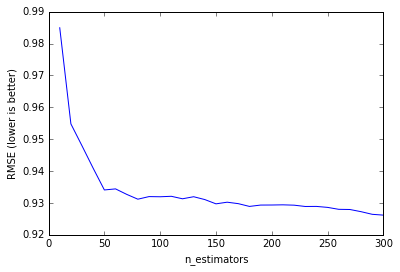

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot n_estimators (x-axis) versus RMSE (y-axis)
plt.plot(estimator_range, RMSE_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE (lower is better)')

In [14]:
n_estimator = 50

In [21]:
# list of values to try for max_features
feature_range = range(1, X.shape[1] +1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=n_estimator, max_features=feature, random_state=1, verbose = 3)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 4

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished



building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.3s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


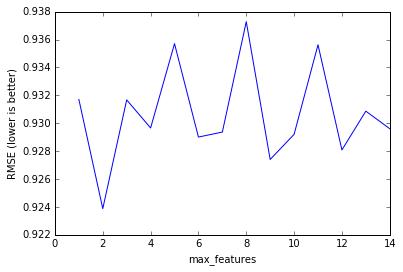

In [22]:
# plot max_features (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, RMSE_scores)
plt.xlabel('max_features')
plt.ylabel('RMSE (lower is better)')

In [23]:
# list of values to try for max_features
depth = range(1,21)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for d in depth:
    rfreg = RandomForestRegressor(n_estimators=n_estimator, max_features=2, random_state=1, verbose = 3, max_depth= d)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s



building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
building tree

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


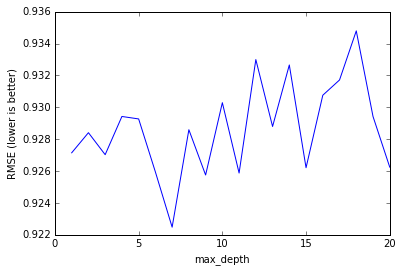

In [24]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [29]:
from sklearn.grid_search import GridSearchCV


param_grid = dict(max_depth = range(1,21), max_features = range(1, X.shape[1] +1), n_estimators = range(10,140,20),verbose=[0])
grid = GridSearchCV(rfreg, param_grid, cv=5, scoring='mean_absolute_error', n_jobs= -1)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=1,
           verbose=3, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 50, 70, 90, 110, 130], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'verbose': [0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [30]:
grid.best_score_

-0.72412414663776581

In [31]:
grid.best_params_

{'max_depth': 12, 'max_features': 3, 'n_estimators': 70, 'verbose': 0}

In [47]:
rfreg = RandomForestRegressor(max_depth= 12, max_features=3, n_estimators= 70, verbose = 3)
MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_absolute_error')

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70


[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.1s


building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


In [48]:
np.mean(MSE_scores)

-0.724045464993753

In [52]:
rfreg.fit(X,y)

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s


building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.5s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=3, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

In [68]:
rfreg = RandomForestRegressor(max_depth= 12, max_features=3, n_estimators= 70, verbose = 3)
MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_absolute_error')

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


In [209]:
MSE_scores = cross_val_score(rfreg, a, movie_ratings.imdbRating, cv=5, scoring='mean_absolute_error')

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 70
building tree 45 of 70
building tree 46 of 70
building tree 47 of 70
building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


building tree 48 of 70
building tree 49 of 70
building tree 50 of 70
building tree 51 of 70
building tree 52 of 70
building tree 53 of 70
building tree 54 of 70
building tree 55 of 70
building tree 56 of 70
building tree 57 of 70
building tree 58 of 70
building tree 59 of 70
building tree 60 of 70
building tree 61 of 70
building tree 62 of 70
building tree 63 of 70
building tree 64 of 70
building tree 65 of 70
building tree 66 of 70
building tree 67 of 70
building tree 68 of 70
building tree 69 of 70
building tree 70 of 70
building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


In [211]:
MSE_scores.mean()


-0.69050899096386287

In [212]:
X = a
y = movie_ratings.imdbRating

In [213]:
param_grid = dict(max_depth = range(1,21), max_features = range(1, X.shape[1] +1), n_estimators = range(10,140,20),verbose=[0])
grid = GridSearchCV(rfreg, param_grid, cv=5, scoring='mean_absolute_error', n_jobs= -1)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=3, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=3, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 50, 70, 90, 110, 130], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'verbose': [0], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [215]:
print grid.best_score_
print grid.best_params_

-0.67609318109
{'max_features': 6, 'n_estimators': 90, 'max_depth': 9, 'verbose': 0}


In [217]:
rfreg.fit(X,y)

building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70
building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70
building tree 10 of 70
building tree 11 of 70
building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70
building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70
building tree 39 of 70
building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=3, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=70, n_jobs=1, oob_score=False, random_state=None,
           verbose=3, warm_start=False)

In [221]:

cv = cross_val_score(LinearRegression(),X,y,cv = 5, scoring = 'mean_absolute_error')

In [222]:
cv.mean()

-0.69464690155760067

In [223]:

treereg = DecisionTreeRegressor()

In [226]:
param_grid = dict(max_depth = range(1,21), max_features = range(1, X.shape[1] +1), min_samples_leaf = range(1,6))
grid = GridSearchCV(treereg, param_grid, cv=5, scoring='mean_absolute_error', n_jobs= -1)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'min_samples_leaf': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [228]:
print grid.best_score_
print grid.best_params_

-0.688906531506
{'max_features': 22, 'max_depth': 3, 'min_samples_leaf': 3}


In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleRegressor(BaseEstimator, ClassifierMixin):


 
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X):
        self.pred_ = np.asarray([model.predict(X) for model in self.models])
        if self.weights:
            avg = np.average(self.pred_, axis=0, weights=self.weights)
        else:
            avg = np.average(self.pred_, axis=0)
        #maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        return avg

In [310]:
models = [RandomForestRegressor(n_estimators=90, max_features = 6, max_depth = 9, verbose = 0),
          DecisionTreeRegressor(max_depth=3, max_features = 22, min_samples_leaf = 3),
          LinearRegression()] 


vc = EnsembleRegressor(models)
np.mean(cross_val_score(vc, X, y, cv=5, scoring='mean_absolute_error'))

-0.68044781369332674

In [316]:
params = {'weights': [[1,2,3],[1,1,4],[1,1,3],[2,2,8]]}

In [317]:
grid = GridSearchCV(vc, params, cv=5, scoring='mean_absolute_error')

In [318]:
grid.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=EnsembleRegressor(clfs=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, ...     splitter='best'), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
         weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'weights': [[1, 2, 3], [1, 1, 4], [1, 1, 3], [2, 2, 8]]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [319]:
print grid.best_score_
print grid.best_params_

-0.679983078155
{'weights': [1, 1, 3]}


In [83]:
from sklearn import decomposition
models = [RandomForestRegressor(n_estimators=90, max_features = 6, max_depth = 9, verbose = 0),
          DecisionTreeRegressor(max_depth=3, max_features = 22, min_samples_leaf = 3),
          LinearRegression()] 


pipe_genre = Pipeline([('select_genre', SelectColumn('Genre')),
                       ('vect', CountVectorizer())])

pipe_script = Pipeline([('select_script', SelectColumn('script')),
                       ('sentiment', SentimentMetrics())])

imdbRating_pipe = Pipeline([('union', FeatureUnion([
                                        ('genre', pipe_genre),
                                        ('script', pipe_script)
                                        ])),
                            ('models', EnsembleRegressor(models, [1,1,3]))])

In [21]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(movie_ratings, movie_ratings.imdbRating)
imdbRating_pipe.fit(X_train,y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('genre', Pipeline(steps=[('select_genre', <__main__.SelectColumn object at 0x000000000C14A4A8>), ('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', i...gression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
         weights=[1, 1, 3]))])

In [22]:
y_pred = imdbRating_pipe.predict(X_test)

In [26]:
preds = pd.DataFrame({'Predction': y_pred, 'Actual': y_test})

In [34]:
preds['error'] = np.abs(preds.Actual - preds.Predction)
print preds.error.mean()

0.702829621419


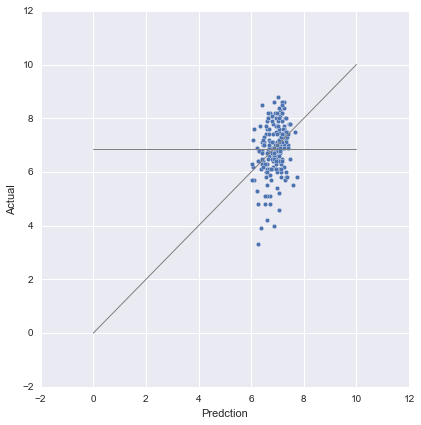

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.pairplot(preds, x_vars=['Predction'], y_vars='Actual', size=6, aspect=1)
plt.plot([0, 10], [0, 10], linewidth=1, c = '0.5')
plt.plot([0, 10], [y_test.mean(), y_test.mean()], linewidth=1, c = '0.5')

In [51]:
fs = FeatureUnion([                          ('genre', pipe_genre),
                                        ('script', pipe_script)
                                        ])

In [52]:
X = fs.fit_transform(movie_ratings)

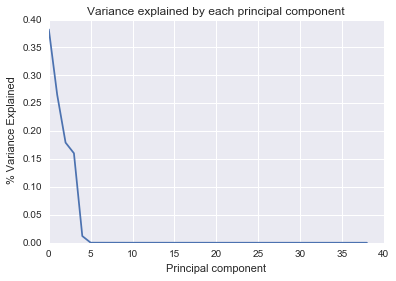

In [58]:
pca = decomposition.PCA()
dense = DenseTransformer()
X_r = pca.fit_transform(dense.transform(X))
plt.plot(pca.explained_variance_ratio_)
plt.title('Variance explained by each principal component')
plt.ylabel(' % Variance Explained')
fplt.xlabel('Principal component')

In [87]:
from sklearn.grid_search import GridSearchCV
params = {'pca__n_components': range(23,X.shape[1])
         }


vc = Pipeline([('dense', DenseTransformer()),('pca', decomposition.PCA(n_components = 29) ) , ('ens', EnsembleRegressor(models, [1,1,3]))])
               
               
grid = GridSearchCV(vc, params, cv=5, scoring='mean_absolute_error')
grid.fit(X, movie_ratings.imdbRating)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('dense', DenseTransformer()), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('ens', EnsembleRegressor(models=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, mi...gression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
         weights=[1, 1, 3]))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [88]:
print grid.best_score_
print grid.best_params_

-0.683799093446
{'pca__n_components': 29}


In [112]:
vc = Pipeline([('dense', DenseTransformer()),('pca', decomposition.PCA(n_components = 29) ) , ('ens', EnsembleRegressor(models, [1,1,3]))])
X_train, X_test, y_train, y_test = train_test_split(X,movie_ratings.imdbRating)
vc.fit(X_train,y_train)

Pipeline(steps=[('dense', DenseTransformer()), ('pca', PCA(copy=True, n_components=29, whiten=False)), ('ens', EnsembleRegressor(models=[RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=6, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_...gression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)],
         weights=[1, 1, 3]))])

In [113]:
y_pred = vc.predict(X_test)



In [120]:
preds = pd.DataFrame({'Prediction': y_pred, 'Actual': y_test})
preds['error'] = np.abs(preds.Actual - preds.Prediction)
print preds.error.mean()

0.653879079828


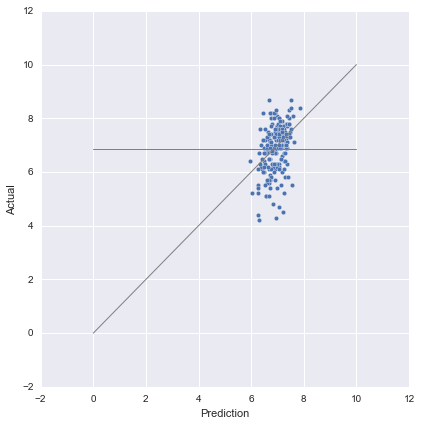

In [134]:
sns.pairplot(preds, x_vars=['Prediction'], y_vars='Actual', size=6, aspect=1)
plt.plot([0, 10], [0, 10], linewidth=1, c = '0.5')
plt.plot([0, 10], [y_test.mean(), y_test.mean()], linewidth=1, c = '0.5')